<a href="https://colab.research.google.com/github/itsmewd/MA0218_Files/blob/main/SAVED_LSTM_FYP_ALL_SAMPLES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from sklearn.metrics import r2_score
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from numpy import linspace
import os
import glob
import math
from tqdm import tqdm
%matplotlib inline

In [ ]:
directory_path ='/content/gdrive/MyDrive/Colab Notebooks/FYP/Layer_1_Image_Data/'

In [ ]:
original_order =[]
for i in range(8,55):
  original_order.append(f"{'E'+str(i)}")

for j in range(1,21):
  original_order.append(f"{'E2-'+str(j)}")

In [ ]:
row_order = []
missingSam=['E13','E16','E18','E20','E21','E22', 'E23', 'E25', 'E31', 'E32', 'E36', 'E40','E50', 'E2-10']

for i in range(8,55):
  sam_name = f"{'E'+str(i)}"
  if sam_name in missingSam:
    pass
  else: 
    row_order.append(sam_name) 

for j in range(1,21):
  vad_name = f"{'E2-'+str(j)}"
  if vad_name in missingSam:
    pass
  else:
    row_order.append(f"{'E2'+'-'+str(j)}")

# Data Preprocessing

In [ ]:

process_parameters = pd.read_excel(directory_path + 'data_list.xlsx', sheet_name='process_parameters', index_col=0, engine='openpyxl')

# rearrange the rows in the dataframe using the list of row order
process_parameters = process_parameters.loc[row_order]

#drop the ratio columns
process_parameters = process_parameters.drop(['XY-incremental Ratio', 'Z-incremental Ratio'], axis=1)
process_parameters

Laser power  Scanning speed  Powder mass flow rate  \
Sample No.                                                       
E8               1600.0          2000.0                 14.000   
E9               1000.0          1600.0                 18.000   
E10              1600.0          2000.0                 14.000   
E11              1600.0          1600.0                 18.000   
E12              1600.0          2000.0                 18.000   
E14              1000.0          2000.0                 14.000   
E15              1600.0          2000.0                 18.000   
E17              1000.0          2000.0                 14.000   
E19              1600.0          1600.0                 14.000   
E24              1000.0          2000.0                 14.000   
E26              1000.0          1600.0                 18.000   
E27              1600.0          2000.0                 18.000   
E28              1600.0          2000.0                 14.000   
E29              1000.0          2000.0                 18.000   
E30              1600.0          1600.0                 14.000   
E33              1600.0          1600.0                 18.000   
E34              1600.0          1600.0                 14.000   
E35              1000.0          2000.0                 18.000   
E37              1600.0          2000.0                 18.000   
E38              1300.0          1800.0                 16.000   
E39              1000.0          1600.0                 14.000   
E41              1300.0          1800.0                 16.000   
E42              1300.0          1800.0                 16.000   
E43              1300.0          1473.4                 16.000   
E44              1300.0          1800.0                 12.734   
E45              1300.0          1800.0                 16.000   
E46              1300.0          1800.0                 16.000   
E47              1789.9          1800.0                 16.000   
E48              1300.0          1800.0                 16.000   
E49              1300.0          1800.0                 16.000   
E51              1300.0          1800.0                 16.000   
E52              1300.0          1800.0                 19.266   
E53               810.1          1800.0                 16.000   
E54              1300.0          2126.6                 16.000   
E2-1             1600.0          2500.0                 18.000   
E2-2             1600.0          2500.0                 18.000   
E2-3             1800.0          3000.0                 16.000   
E2-4             1400.0          2000.0                 16.000   
E2-5             1400.0          2000.0                 16.000   
E2-6             1400.0          3000.0                 20.000   
E2-7             1800.0          2000.0                 20.000   
E2-8             1400.0          3000.0                 16.000   
E2-9             1400.0          3000.0                 16.000   
E2-11            1400.0          2000.0                 20.000   
E2-12            1600.0          2500.0                 18.000   
E2-13            1800.0          3000.0                 20.000   
E2-14            1800.0          3000.0                 16.000   
E2-15            1800.0          3000.0                 20.000   
E2-16            1600.0          2500.0                 18.000   
E2-17            1400.0          3000.0                 20.000   
E2-18            1800.0          2000.0                 16.000   
E2-19            1800.0          2000.0                 16.000   
E2-20            1800.0          2000.0                 20.000   

            Hatching Spacing  Z-incremental value  
Sample No.                                         
E8                      1089                  571  
E9                      1292                  798  
E10                     1525                  762  
E11                     1047                  808  
E12                     1003                  930  
E14              

In [ ]:
# Define the path of the csv files
path = '/content/gdrive/MyDrive/Colab Notebooks/FYP/Coefficient_Files/'

# Create an empty list to store the dataframes
df_list = []

# Loop through each csv file
for file in os.listdir(path):
    if file.endswith('.csv'):
        # Extract the layer_num from the file name
        layer_num = file.split('_')[0]

        # Load the csv file
        df = pd.read_csv(os.path.join(path, file))

        # Extract the required columns
        df = df[['a', 'b', 'c', 'sample_name']]

        # Add the layer_num column
        df['layer_num'] = layer_num

        # Append the dataframe to df_list
        df_list.append(df)

# Concatenate the dataframes in df_list
coef_df = pd.concat(df_list, ignore_index=True)

# Sort the data by sample_name and layer_num
coef_df = coef_df.sort_values(['sample_name', 'layer_num'])

# Reset the index of the dataframe
coef_df = coef_df.reset_index(drop=True)

# Create a categorical variable based on the sample_name column using the original_order
coef_df['sample_name'] = pd.Categorical(coef_df['sample_name'], categories=original_order, ordered=True)

# Sort the dataframe by the categorical variable and layer_num
coef_df = coef_df.sort_values(['sample_name', 'layer_num'])

# Reset the index of the dataframe
coef_df = coef_df.reset_index(drop=True)

#drop missing_sample from columns
coef_df = coef_df[~coef_df['sample_name'].isin(missingSam)]

coef_df

a             b            c sample_name layer_num
0    -0.000259 -4.101677e-15   754.434622          E8        L1
1    -0.000281  2.336665e-01   719.505058          E8        L1
2    -0.000177 -1.415789e-01   719.200322          E8        L1
3    -0.000254  1.004860e-01   717.772908          E8        L1
4    -0.000247 -1.853783e-01   689.383024          E8        L1
...        ...           ...          ...         ...       ...
3784 -0.000398 -1.712505e-01   952.571660       E2-20        L6
3785 -0.000481 -1.784334e-01   995.873942       E2-20        L6
3786 -0.000350 -4.009468e-02   957.958145       E2-20        L6
3787 -0.000374  8.414698e-02  1047.312051       E2-20        L6
3788 -0.000587  6.727611e-01   866.715034       E2-20        L6

[3789 rows x 5 columns]

In [ ]:
# Remove complex numbers 
# Create a mask for the conditions
noncomplex = (coef_df['a'] < 0) & (coef_df['c'] > 0) & (coef_df['b']**2 >= 4 * coef_df['a'] * coef_df['c'])

# Apply the mask to the DataFrame
coef_df = coef_df[noncomplex]

In [ ]:
coef_df

a             b            c sample_name layer_num
0    -0.000259 -4.101677e-15   754.434622          E8        L1
1    -0.000281  2.336665e-01   719.505058          E8        L1
2    -0.000177 -1.415789e-01   719.200322          E8        L1
3    -0.000254  1.004860e-01   717.772908          E8        L1
4    -0.000247 -1.853783e-01   689.383024          E8        L1
...        ...           ...          ...         ...       ...
3784 -0.000398 -1.712505e-01   952.571660       E2-20        L6
3785 -0.000481 -1.784334e-01   995.873942       E2-20        L6
3786 -0.000350 -4.009468e-02   957.958145       E2-20        L6
3787 -0.000374  8.414698e-02  1047.312051       E2-20        L6
3788 -0.000587  6.727611e-01   866.715034       E2-20        L6

[3659 rows x 5 columns]

In [ ]:
# Add group_index column
coef_df['group_index'] = (coef_df['layer_num'] != coef_df['layer_num'].shift()).cumsum()

# Group by group_index
groups = coef_df.groupby('group_index')

# Create a new dataframe with modified groups
shift_coef = pd.DataFrame()
for name, group in groups:

    # Drop sample_name column
    #group = group.drop(['sample_name'], axis=1)
    
    # Insert a row of zeros at the beginning of each group
    zero_row = pd.DataFrame([0]*len(group.columns)).T
    zero_row.columns = group.columns
    
    # Fill layer_num & sample_name for the zero row with the previous value
    zero_row['layer_num'] = group['layer_num'].shift().iloc[-1]
    zero_row['sample_name'] = group['sample_name'].shift().iloc[-2]
    
    # Concatenate the zero row with the original group
    group = pd.concat([zero_row, group], ignore_index=True)
    
    # Remove the last row of each group
    group = group[:-1]
    
    # Append the modified group to the new dataframe
    shift_coef = pd.concat([shift_coef, group], ignore_index=True)

# Remove the group_index column from the new dataframe
shift_coef = shift_coef.drop('group_index', axis=1)

shift_coef.head()

<ipython-input-10-a8e580142678>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coef_df['group_index'] = (coef_df['layer_num'] != coef_df['layer_num'].shift()).cumsum()


a             b           c sample_name layer_num
0  0.000000  0.000000e+00    0.000000          E8        L1
1 -0.000259 -4.101677e-15  754.434622          E8        L1
2 -0.000281  2.336665e-01  719.505058          E8        L1
3 -0.000177 -1.415789e-01  719.200322          E8        L1
4 -0.000254  1.004860e-01  717.772908          E8        L1

In [ ]:
z_multiplier = {f"L{i}": i-1 for i in range(1, 7)}  # create a dictionary to map layer_num to multiplier

new_params_list = []  # a list to store new dataframes for each sample

for sample_name in coef_df['sample_name'].unique():
    
    sample_coef = coef_df[coef_df['sample_name'] == sample_name]
    sample_params = process_parameters.loc[sample_name]
    
    # calculate z_incremental_value
    z_incremental_values = []
    for layer_num in sample_coef['layer_num'].unique():
        layer_coef = sample_coef[sample_coef['layer_num']==layer_num]
        num_curves = len(layer_coef)
        multiplier = z_multiplier[layer_num]  # look up the multiplier for this layer
        z_incremental_value = sample_params['Z-incremental value'] * multiplier * np.ones(num_curves)
        z_incremental_values.append(z_incremental_value)
    z_incremental_values = np.concatenate(z_incremental_values)
    
    # calculate hatch_spacing
    hatch_spacings = []
    for layer_num in sample_coef['layer_num'].unique():
        layer_coef = sample_coef[sample_coef['layer_num']==layer_num]
        num_curves = len(layer_coef)
        hatch_spacing = sample_params['Hatching Spacing'] * np.arange(num_curves)
        hatch_spacings.append(hatch_spacing)
    hatch_spacings = np.concatenate(hatch_spacings)
    
    # create new dataframe
    new_params = pd.DataFrame({
        'Laser power': sample_params['Laser power'],
        'Scanning speed': sample_params['Scanning speed'],
        'Powder mass flow rate': sample_params['Powder mass flow rate'],
        'Hatching Spacing': hatch_spacings,
        'Z-incremental value': z_incremental_values,
    }, index=sample_coef.index)
    new_params_list.append(new_params)

# concatenate all new dataframes into one
new_params_df = pd.concat(new_params_list)
new_params_df

Laser power  Scanning speed  Powder mass flow rate  Hatching Spacing  \
0          1600.0          2000.0                   14.0               0.0   
1          1600.0          2000.0                   14.0            1089.0   
2          1600.0          2000.0                   14.0            2178.0   
3          1600.0          2000.0                   14.0            3267.0   
4          1600.0          2000.0                   14.0            4356.0   
...           ...             ...                    ...               ...   
3784       1800.0          2000.0                   20.0            4115.0   
3785       1800.0          2000.0                   20.0            4938.0   
3786       1800.0          2000.0                   20.0            5761.0   
3787       1800.0          2000.0                   20.0            6584.0   
3788       1800.0          2000.0                   20.0            7407.0   

      Z-incremental value  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0  
...                   ...  
3784               4510.0  
3785               4510.0  
3786               4510.0  
3787               4510.0  
3788               4510.0  

[3659 rows x 5 columns]

In [ ]:
shift_coef

a             b            c sample_name layer_num
0     0.000000  0.000000e+00     0.000000          E8        L1
1    -0.000259 -4.101677e-15   754.434622          E8        L1
2    -0.000281  2.336665e-01   719.505058          E8        L1
3    -0.000177 -1.415789e-01   719.200322          E8        L1
4    -0.000254  1.004860e-01   717.772908          E8        L1
...        ...           ...          ...         ...       ...
3654 -0.000512 -3.992103e-02   945.551845       E2-20        L6
3655 -0.000398 -1.712505e-01   952.571660       E2-20        L6
3656 -0.000481 -1.784334e-01   995.873942       E2-20        L6
3657 -0.000350 -4.009468e-02   957.958145       E2-20        L6
3658 -0.000374  8.414698e-02  1047.312051       E2-20        L6

[3659 rows x 5 columns]

In [ ]:
# concatenate the params_df and shift_coef to form a single input dataset
input_df = pd.concat([new_params_df.reset_index(drop=True), shift_coef.reset_index(drop=True)], axis=1)
input_df

Laser power  Scanning speed  Powder mass flow rate  Hatching Spacing  \
0          1600.0          2000.0                   14.0               0.0   
1          1600.0          2000.0                   14.0            1089.0   
2          1600.0          2000.0                   14.0            2178.0   
3          1600.0          2000.0                   14.0            3267.0   
4          1600.0          2000.0                   14.0            4356.0   
...           ...             ...                    ...               ...   
3654       1800.0          2000.0                   20.0            4115.0   
3655       1800.0          2000.0                   20.0            4938.0   
3656       1800.0          2000.0                   20.0            5761.0   
3657       1800.0          2000.0                   20.0            6584.0   
3658       1800.0          2000.0                   20.0            7407.0   

      Z-incremental value         a             b            c sample_name  \
0                     0.0  0.000000  0.000000e+00     0.000000          E8   
1                     0.0 -0.000259 -4.101677e-15   754.434622          E8   
2                     0.0 -0.000281  2.336665e-01   719.505058          E8   
3                     0.0 -0.000177 -1.415789e-01   719.200322          E8   
4                     0.0 -0.000254  1.004860e-01   717.772908          E8   
...                   ...       ...           ...          ...         ...   
3654               4510.0 -0.000512 -3.992103e-02   945.551845       E2-20   
3655               4510.0 -0.000398 -1.712505e-01   952.571660       E2-20   
3656               4510.0 -0.000481 -1.784334e-01   995.873942       E2-20   
3657               4510.0 -0.000350 -4.009468e-02   957.958145       E2-20   
3658               4510.0 -0.000374  8.414698e-02  1047.312051       E2-20   

     layer_num  
0           L1  
1           L1  
2           L1  
3           L1  
4           L1  
...        ...  
3654        L6  
3655        L6  
3656        L6  
3657        L6  
3658        L6  

[3659 rows x 10 columns]

In [ ]:
coef_df['curve_num'] = 0  # Initialize the curve_num column to 0

# Loop through each unique combination of sample_name and layer_num
for name, group in coef_df.groupby(['sample_name', 'layer_num']):
    # Reset the curve_num counter for each group
    curve_num = 0
    # Update the curve_num column for each row in the group
    for i, row in group.iterrows():
        coef_df.loc[i, 'curve_num'] = curve_num
        curve_num += 1
        
#Shift the curve_num column before group_index
coef_df.insert(coef_df.columns.get_loc('group_index'), 'curve_num_shifted', coef_df['curve_num'])
coef_df = coef_df.drop('curve_num', axis=1)
coef_df = coef_df.rename(columns={'curve_num_shifted': 'curve_num'})

<ipython-input-14-9ca0db881e09>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coef_df['curve_num'] = 0  # Initialize the curve_num column to 0


In [ ]:
coef_df

a             b            c sample_name layer_num  curve_num  \
0    -0.000259 -4.101677e-15   754.434622          E8        L1          0   
1    -0.000281  2.336665e-01   719.505058          E8        L1          1   
2    -0.000177 -1.415789e-01   719.200322          E8        L1          2   
3    -0.000254  1.004860e-01   717.772908          E8        L1          3   
4    -0.000247 -1.853783e-01   689.383024          E8        L1          4   
...        ...           ...          ...         ...       ...        ...   
3784 -0.000398 -1.712505e-01   952.571660       E2-20        L6          5   
3785 -0.000481 -1.784334e-01   995.873942       E2-20        L6          6   
3786 -0.000350 -4.009468e-02   957.958145       E2-20        L6          7   
3787 -0.000374  8.414698e-02  1047.312051       E2-20        L6          8   
3788 -0.000587  6.727611e-01   866.715034       E2-20        L6          9   

      group_index  
0               1  
1               1  
2               1  
3               1  
4               1  
...           ...  
3784          318  
3785          318  
3786          318  
3787          318  
3788          318  

[3659 rows x 7 columns]

In [ ]:
input_df

Laser power  Scanning speed  Powder mass flow rate  Hatching Spacing  \
0          1600.0          2000.0                   14.0               0.0   
1          1600.0          2000.0                   14.0            1089.0   
2          1600.0          2000.0                   14.0            2178.0   
3          1600.0          2000.0                   14.0            3267.0   
4          1600.0          2000.0                   14.0            4356.0   
...           ...             ...                    ...               ...   
3654       1800.0          2000.0                   20.0            4115.0   
3655       1800.0          2000.0                   20.0            4938.0   
3656       1800.0          2000.0                   20.0            5761.0   
3657       1800.0          2000.0                   20.0            6584.0   
3658       1800.0          2000.0                   20.0            7407.0   

      Z-incremental value         a             b            c sample_name  \
0                     0.0  0.000000  0.000000e+00     0.000000          E8   
1                     0.0 -0.000259 -4.101677e-15   754.434622          E8   
2                     0.0 -0.000281  2.336665e-01   719.505058          E8   
3                     0.0 -0.000177 -1.415789e-01   719.200322          E8   
4                     0.0 -0.000254  1.004860e-01   717.772908          E8   
...                   ...       ...           ...          ...         ...   
3654               4510.0 -0.000512 -3.992103e-02   945.551845       E2-20   
3655               4510.0 -0.000398 -1.712505e-01   952.571660       E2-20   
3656               4510.0 -0.000481 -1.784334e-01   995.873942       E2-20   
3657               4510.0 -0.000350 -4.009468e-02   957.958145       E2-20   
3658               4510.0 -0.000374  8.414698e-02  1047.312051       E2-20   

     layer_num  
0           L1  
1           L1  
2           L1  
3           L1  
4           L1  
...        ...  
3654        L6  
3655        L6  
3656        L6  
3657        L6  
3658        L6  

[3659 rows x 10 columns]

In [ ]:
# Filter input_df based on the desired conditions
new_df = input_df[(input_df['sample_name'] == 'E44') & (input_df['layer_num'] == 'L6')]
new_df

Laser power  Scanning speed  Powder mass flow rate  Hatching Spacing  \
1561       1300.0          1800.0                 12.734               0.0   
1562       1300.0          1800.0                 12.734            1178.0   
1563       1300.0          1800.0                 12.734            2356.0   
1564       1300.0          1800.0                 12.734            3534.0   
1565       1300.0          1800.0                 12.734            4712.0   
1566       1300.0          1800.0                 12.734            5890.0   
1567       1300.0          1800.0                 12.734            7068.0   
1568       1300.0          1800.0                 12.734            8246.0   
1569       1300.0          1800.0                 12.734            9424.0   
1570       1300.0          1800.0                 12.734           10602.0   

      Z-incremental value         a             b           c sample_name  \
1561               2850.0  0.000000  0.000000e+00    0.000000         E44   
1562               2850.0 -0.000631  2.515848e-16  577.552289         E44   
1563               2850.0 -0.000464 -3.904881e-01  664.115396         E44   
1564               2850.0 -0.000395 -4.140895e-01  555.840129         E44   
1565               2850.0 -0.000581 -6.440941e-01  583.145645         E44   
1566               2850.0 -0.000423 -6.383625e-01  496.049283         E44   
1567               2850.0 -0.000567 -6.179507e-01  670.434770         E44   
1568               2850.0 -0.000470 -6.380205e-01  564.269149         E44   
1569               2850.0 -0.000403 -5.487860e-01  610.311191         E44   
1570               2850.0 -0.000330 -4.584509e-01  612.778849         E44   

     layer_num  
1561        L6  
1562        L6  
1563        L6  
1564        L6  
1565        L6  
1566        L6  
1567        L6  
1568        L6  
1569        L6  
1570        L6

In [ ]:
from sklearn.preprocessing import MinMaxScaler
process_parameters_scaler = MinMaxScaler()
input_df[input_df.columns[:-2]] = process_parameters_scaler.fit_transform(input_df[input_df.columns[:-2]])

scaler = MinMaxScaler()
coef_df[coef_df.columns[:-4]] = scaler.fit_transform(coef_df[coef_df.columns[:-4]])



In [ ]:
input_df

Laser power  Scanning speed  Powder mass flow rate  Hatching Spacing  \
0        0.797959         0.34495               0.174236          0.000000   
1        0.797959         0.34495               0.174236          0.051141   
2        0.797959         0.34495               0.174236          0.102282   
3        0.797959         0.34495               0.174236          0.153423   
4        0.797959         0.34495               0.174236          0.204565   
...           ...             ...                    ...               ...   
3654     1.000000         0.34495               1.000000          0.193247   
3655     1.000000         0.34495               1.000000          0.231896   
3656     1.000000         0.34495               1.000000          0.270546   
3657     1.000000         0.34495               1.000000          0.309195   
3658     1.000000         0.34495               1.000000          0.347844   

      Z-incremental value         a         b         c sample_name layer_num  
0                0.000000  1.000000  0.463378  0.000000          E8        L1  
1                0.000000  0.843260  0.463378  0.491448          E8        L1  
2                0.000000  0.829875  0.528413  0.468695          E8        L1  
3                0.000000  0.892984  0.423973  0.468496          E8        L1  
4                0.000000  0.846070  0.491346  0.467567          E8        L1  
...                   ...       ...       ...       ...         ...       ...  
3654             0.778257  0.689417  0.452267  0.615945       E2-20        L6  
3655             0.778257  0.759049  0.415715  0.620517       E2-20        L6  
3656             0.778257  0.708716  0.413715  0.648725       E2-20        L6  
3657             0.778257  0.787769  0.452219  0.624026       E2-20        L6  
3658             0.778257  0.773549  0.486798  0.682233       E2-20        L6  

[3659 rows x 10 columns]

In [ ]:
train_inputs = []
train_outputs = []
val_inputs = []
val_outputs = []
test_inputs = []
test_outputs = []
identity = []

samples = input_df["sample_name"].unique()

for sample in samples:
    sample_df = input_df[input_df["sample_name"] == sample]
    sample_coef_df = coef_df[coef_df["sample_name"] == sample]

    train_size = int(0.8 * len(sample_df))
    test_size = len(sample_df) - train_size

    train_df = sample_df.iloc[:train_size].drop(['sample_name', 'layer_num'], axis=1)
    test_df = sample_df.iloc[train_size:].drop(['sample_name', 'layer_num'], axis=1)

    train_coef_df = sample_coef_df.iloc[:train_size].drop(['sample_name', 'layer_num', 'curve_num', 'group_index'], axis=1)
    test_coef_df = sample_coef_df.iloc[train_size:].drop(['group_index'], axis=1)
    
    # Extract identity information
    test_identity = test_coef_df[['sample_name', 'layer_num','curve_num']].values.tolist()

    val_size = int(0.2 * len(train_df))
    train_size = len(train_df) - val_size

    val_df = train_df.iloc[train_size:]
    train_df = train_df.iloc[:train_size]

    val_coef_df = train_coef_df.iloc[train_size:]
    train_coef_df = train_coef_df.iloc[:train_size]

    # Apply sliding window to the data
    window_size = 1
    for j in range(len(train_df) - window_size + 1):
        train_inputs.append(train_df.iloc[j:j+window_size].values)
        train_outputs.append(train_coef_df.iloc[j:j+window_size].values)

    for j in range(len(val_df) - window_size + 1):
        val_inputs.append(val_df.iloc[j:j+window_size].values)
        val_outputs.append(val_coef_df.iloc[j:j+window_size].values)

    for j in range(len(test_df) - window_size + 1):
        test_inputs.append(test_df.iloc[j:j+window_size].values)
        test_outputs.append(test_coef_df.iloc[j:j+window_size].drop(['sample_name', 'layer_num', 'curve_num'], axis=1).values)
        identity.append(test_identity[j])

# Convert to numpy arrays
train_inputs = np.array(train_inputs)
train_outputs = np.array(train_outputs)
val_inputs = np.array(val_inputs)
val_outputs = np.array(val_outputs)
test_inputs = np.array(test_inputs)
test_outputs = np.array(test_outputs)

# For use in post processing
test_identity = np.array(identity)

In [ ]:
# Convert train, validation and testing sets into PyTorch tensors
train_inputs = torch.tensor(train_inputs, dtype=torch.float32)
train_outputs = torch.tensor(train_outputs, dtype=torch.float32)
val_inputs = torch.tensor(val_inputs, dtype=torch.float32)
val_outputs = torch.tensor(val_outputs, dtype=torch.float32)
test_inputs = torch.tensor(test_inputs, dtype=torch.float32)
test_outputs = torch.tensor(test_outputs, dtype=torch.float32)

print('train input shape: ', train_inputs.shape)
print('train output shape: ', train_outputs.shape)
print('validation input shape: ', val_inputs.shape)
print('validation output shape: ', val_outputs.shape)
print('test input shape: ', test_inputs.shape)
print('test output shape: ', test_outputs.shape)

train input shape:  torch.Size([2340, 1, 8])
train output shape:  torch.Size([2340, 1, 3])
validation input shape:  torch.Size([561, 1, 8])
validation output shape:  torch.Size([561, 1, 3])
test input shape:  torch.Size([751, 1, 8])
test output shape:  torch.Size([751, 1, 3])


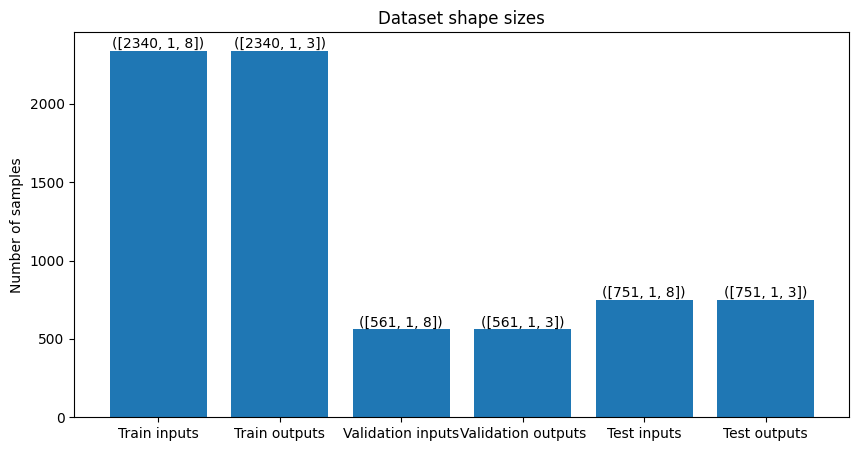

In [ ]:
def visualize_data_shapes(train_inputs, train_outputs, val_inputs, val_outputs, test_inputs, test_outputs):
    data_shapes = [
        ('Train inputs', train_inputs.shape),
        ('Train outputs', train_outputs.shape),
        ('Validation inputs', val_inputs.shape),
        ('Validation outputs', val_outputs.shape),
        ('Test inputs', test_inputs.shape),
        ('Test outputs', test_outputs.shape)
    ]

    labels, shapes = zip(*data_shapes)

    plt.figure(figsize=(10, 5))
    plt.bar(labels, [shape[0] for shape in shapes])
    plt.ylabel('Number of samples')
    plt.title('Dataset shape sizes')

    for i, shape in enumerate(shapes):
        shape_str = str(shape).replace("torch.Size", "").strip("[]")  # Convert shape to string and remove "torch.Size"
        plt.text(i, shape[0], f"{shape_str}", ha='center', va='bottom')

    plt.show()

# Call the function with your data
visualize_data_shapes(train_inputs, train_outputs, val_inputs, val_outputs, test_inputs, test_outputs)

# LSTM Model Building

In [ ]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, output_size)

        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)

        nn.init.xavier_uniform_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)

    def forward(self, input_seq):
        batch_size, seq_len, _ = input_seq.size()
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(input_seq.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(input_seq.device)

        lstm_out, _ = self.lstm(input_seq, (h0, c0))
        output_seq = self.linear(lstm_out.contiguous().view(-1, self.hidden_size))
        output_seq = output_seq.view(batch_size, seq_len, -1)

        return output_seq

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Add early stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0001):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss <= self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# Random Search for Best Hyperparameters

In [ ]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import random

def sample_hyperparameters(space):
    return {key: random.choice(values) for key, values in space.items()}

In [ ]:
def train_model(hyperparameters):
    # Unpack the hyperparameters
    hidden_size = hyperparameters['hidden_size']
    batch_size = hyperparameters['batch_size']
    num_epochs = hyperparameters['num_epochs']
    learning_rate = hyperparameters['learning_rate']
    num_layers = hyperparameters['num_layers']
    dropout = hyperparameters['dropout']
    weight_decay = hyperparameters['weight_decay']
    input_size = train_inputs.shape[-1]
    output_size = train_outputs.shape[-1]
    patience = 0

    # Define datasets and data loaders for training and testing
    train_dataset = MyDataset(train_inputs, train_outputs)
    val_dataset = MyDataset(val_inputs, val_outputs)
    test_dataset = MyDataset(test_inputs, test_outputs)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Create model and optimizer
    model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    #optimizer = AdaBelief(model.parameters(), lr=learning_rate, print_change_log = False)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0, verbose=True)
    criterion = nn.MSELoss()

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience)

    train_losses, val_losses, test_losses = [], [], []

    # Define the progress bar
    progress_bar = tqdm(range(num_epochs), desc='Epoch', position=0)
    # Train the model
    for epoch in progress_bar:
        train_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            output_seq = model(batch_x)
            loss = criterion(output_seq, batch_y) 
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_x.shape[0]
        train_loss /= len(train_dataset)
        train_losses.append(train_loss)

        # Calculate validation loss
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                output_seq = model(batch_x)
                loss = criterion(output_seq, batch_y)
                val_loss += loss.item() * batch_x.shape[0]
            val_losses.append(val_loss)
            val_loss /= len(val_dataset)

        scheduler.step(val_loss)  # Learning rate scheduling

        # Test the model
        test_loss = 0.0
        test_predictions = []
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                output_seq = model(batch_x)
                loss = criterion(output_seq, batch_y)
                test_loss += loss.item() * batch_x.shape[0]
                test_predictions.append(output_seq.detach().cpu().numpy())

            test_loss /= len(test_dataset)
            test_losses.append(test_loss)

        # Update the progress bar
        progress_bar.set_postfix({'Train Loss': f'{train_loss:.6f}', 'Val Loss': f'{val_loss:.6f}', 'Test Loss': f'{test_loss:.6f}'})

        # Check for early stopping
        if early_stopping(val_loss):
            print(f"Early stopping after {epoch+1} epochs")
            break

        # After the training loop and early stopping check, save the model
        torch.save(model.state_dict(), "lstm_model.pth")

        test_predictions = np.concatenate(test_predictions)

        test_outputs_np = test_outputs.numpy()
        test_outputs_np

        # Flatten the denormalized test predictions and actual outputs
        test_predictions_flat = test_predictions.flatten()
        test_outputs_flat = test_outputs_np.flatten()

        # Calculate R^2 score
        test_r2 = r2_score(test_outputs_flat, test_predictions_flat)

    # Return the best validation loss
    return test_r2

In [ ]:
# Define the hyperparameter search space
hyperparameter_space = {
    'hidden_size': [ 256, 512],
    'batch_size': [1, 4, 8],
    'num_epochs': [20, 30],
    'learning_rate': [1e-3, 1e-4, 1e-5],
    'num_layers': [1, 2],
    'dropout': [0.0, 0.1, 0.2],
    'weight_decay': [0.0, 1e-5, 1e-4, 1e-6],
}

input_size = train_inputs.shape[-1]
output_size = train_outputs.shape[-1]

# Number of random search iterations
num_iterations = 20

# Track the best R2 score and corresponding hyperparameters
best_r2 = -1e9
best_hyperparameters = None

# Initialize an empty DataFrame for storing the results
search_df = pd.DataFrame(columns=['input_size', 'output_size', 'hidden_size', 'batch_size', 'num_epochs', 'learning_rate', 'num_layers', 'dropout', 'weight_decay', 'test_r2'])

# Perform random search
for i in range(num_iterations):
    print('--------------------------------------------------------------------------------------------------------------------------')
    print(f"Random search iteration {i+1}/{num_iterations}")

    # Sample random hyperparameters
    hyperparameters = {k: random.choice(v) for k, v in hyperparameter_space.items()}
    print(f"Trying hyperparameters: {hyperparameters}")

    # Train the model and get the test R2 score
    test_r2 = train_model(hyperparameters)
    print(f"Test R2 score: {test_r2}")

    # Update the best R2 score and hyperparameters if necessary
    if test_r2 > best_r2:
        best_r2 = test_r2
        best_hyperparameters = hyperparameters
        print(f"New best R2 score: {best_r2}")
        print(f"New best hyperparameters: {best_hyperparameters}")

    # Append the results to the search_df DataFrame with a custom index
    results = {
        'input_size': input_size,
        'output_size': output_size,
        'hidden_size': hyperparameters['hidden_size'],
        'batch_size': hyperparameters['batch_size'],
        'num_epochs': hyperparameters['num_epochs'],
        'learning_rate': hyperparameters['learning_rate'],
        'num_layers': hyperparameters['num_layers'],
        'dropout': hyperparameters['dropout'],
        'weight_decay': hyperparameters['weight_decay'],
        'test_r2': test_r2
    }
    index_name = f'Trial {i+1}'
    search_df = pd.concat([search_df, pd.DataFrame(results, index=[index_name])])

print("Random search completed")
print(f"Best R2 score: {best_r2}")
print(f"Best hyperparameters: {best_hyperparameters}")



--------------------------------------------------------------------------------------------------------------------------
Random search iteration 1/20
Trying hyperparameters: {'hidden_size': 512, 'batch_size': 4, 'num_epochs': 30, 'learning_rate': 0.001, 'num_layers': 1, 'dropout': 0.0, 'weight_decay': 0.0001}


Epoch:  23%|██▎       | 7/30 [00:12<00:39,  1.72s/it, Train Loss=0.007540, Val Loss=0.011949, Test Loss=0.014189]


Early stopping after 8 epochs
Test R2 score: 0.5857594154636252
New best R2 score: 0.5857594154636252
New best hyperparameters: {'hidden_size': 512, 'batch_size': 4, 'num_epochs': 30, 'learning_rate': 0.001, 'num_layers': 1, 'dropout': 0.0, 'weight_decay': 0.0001}
--------------------------------------------------------------------------------------------------------------------------
Random search iteration 2/20
Trying hyperparameters: {'hidden_size': 256, 'batch_size': 1, 'num_epochs': 30, 'learning_rate': 0.001, 'num_layers': 1, 'dropout': 0.0, 'weight_decay': 1e-06}


Epoch:  33%|███▎      | 10/30 [01:00<02:01,  6.07s/it, Train Loss=0.004550, Val Loss=0.006244, Test Loss=0.010218]
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Early stopping after 11 epochs
Test R2 score: 0.7054251095213844
New best R2 score: 0.7054251095213844
New best hyperparameters: {'hidden_size': 256, 'batch_size': 1, 'num_epochs': 30, 'learning_rate': 0.001, 'num_layers': 1, 'dropout': 0.0, 'weight_decay': 1e-06}
--------------------------------------------------------------------------------------------------------------------------
Random search iteration 3/20
Trying hyperparameters: {'hidden_size': 512, 'batch_size': 1, 'num_epochs': 30, 'learning_rate': 0.0001, 'num_layers': 1, 'dropout': 0.1, 'weight_decay': 1e-06}


Epoch:  77%|███████▋  | 23/30 [02:21<00:43,  6.16s/it, Train Loss=0.004713, Val Loss=0.006455, Test Loss=0.008300]


Early stopping after 24 epochs
Test R2 score: 0.7608261328064516
New best R2 score: 0.7608261328064516
New best hyperparameters: {'hidden_size': 512, 'batch_size': 1, 'num_epochs': 30, 'learning_rate': 0.0001, 'num_layers': 1, 'dropout': 0.1, 'weight_decay': 1e-06}
--------------------------------------------------------------------------------------------------------------------------
Random search iteration 4/20
Trying hyperparameters: {'hidden_size': 512, 'batch_size': 4, 'num_epochs': 30, 'learning_rate': 0.0001, 'num_layers': 1, 'dropout': 0.0, 'weight_decay': 0.0001}


Epoch:  30%|███       | 9/30 [00:15<00:35,  1.67s/it, Train Loss=0.006596, Val Loss=0.009000, Test Loss=0.011268]


Early stopping after 10 epochs
Test R2 score: 0.671384482392636
--------------------------------------------------------------------------------------------------------------------------
Random search iteration 5/20
Trying hyperparameters: {'hidden_size': 256, 'batch_size': 4, 'num_epochs': 20, 'learning_rate': 1e-05, 'num_layers': 2, 'dropout': 0.0, 'weight_decay': 1e-05}


Epoch: 100%|██████████| 20/20 [00:30<00:00,  1.54s/it, Train Loss=0.008874, Val Loss=0.011987, Test Loss=0.014498]


Test R2 score: 0.5833723154889112
--------------------------------------------------------------------------------------------------------------------------
Random search iteration 6/20
Trying hyperparameters: {'hidden_size': 512, 'batch_size': 4, 'num_epochs': 20, 'learning_rate': 0.0001, 'num_layers': 1, 'dropout': 0.0, 'weight_decay': 0.0001}


Epoch:  45%|████▌     | 9/20 [00:15<00:18,  1.67s/it, Train Loss=0.006598, Val Loss=0.009019, Test Loss=0.011313]
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Early stopping after 10 epochs
Test R2 score: 0.6695553906206608
--------------------------------------------------------------------------------------------------------------------------
Random search iteration 7/20
Trying hyperparameters: {'hidden_size': 256, 'batch_size': 4, 'num_epochs': 30, 'learning_rate': 0.001, 'num_layers': 1, 'dropout': 0.2, 'weight_decay': 1e-06}


Epoch:  27%|██▋       | 8/30 [00:12<00:34,  1.58s/it, Train Loss=0.006473, Val Loss=0.008938, Test Loss=0.010008]


Early stopping after 9 epochs
Test R2 score: 0.7122536042232392
--------------------------------------------------------------------------------------------------------------------------
Random search iteration 8/20
Trying hyperparameters: {'hidden_size': 256, 'batch_size': 4, 'num_epochs': 20, 'learning_rate': 0.0001, 'num_layers': 2, 'dropout': 0.1, 'weight_decay': 1e-05}


Epoch:  35%|███▌      | 7/20 [00:12<00:23,  1.80s/it, Train Loss=0.007070, Val Loss=0.009321, Test Loss=0.011715]


Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.
Early stopping after 8 epochs
Test R2 score: 0.6640888505654043
--------------------------------------------------------------------------------------------------------------------------
Random search iteration 9/20
Trying hyperparameters: {'hidden_size': 256, 'batch_size': 8, 'num_epochs': 20, 'learning_rate': 0.0001, 'num_layers': 2, 'dropout': 0.2, 'weight_decay': 0.0}


Epoch:  55%|█████▌    | 11/20 [00:09<00:07,  1.14it/s, Train Loss=0.007118, Val Loss=0.009791, Test Loss=0.012299]


Epoch 00012: reducing learning rate of group 0 to 1.0000e-05.
Early stopping after 12 epochs
Test R2 score: 0.6466051266574476
--------------------------------------------------------------------------------------------------------------------------
Random search iteration 10/20
Trying hyperparameters: {'hidden_size': 512, 'batch_size': 1, 'num_epochs': 30, 'learning_rate': 0.0001, 'num_layers': 2, 'dropout': 0.2, 'weight_decay': 0.0001}


Epoch:  23%|██▎       | 7/30 [00:55<03:02,  7.92s/it, Train Loss=0.007069, Val Loss=0.012170, Test Loss=0.014844]

Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.


Epoch:  23%|██▎       | 7/30 [01:03<03:29,  9.11s/it, Train Loss=0.007032, Val Loss=0.012169, Test Loss=0.014692]
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Early stopping after 8 epochs
Test R2 score: 0.5734211423944466
--------------------------------------------------------------------------------------------------------------------------
Random search iteration 11/20
Trying hyperparameters: {'hidden_size': 256, 'batch_size': 1, 'num_epochs': 30, 'learning_rate': 0.001, 'num_layers': 1, 'dropout': 0.2, 'weight_decay': 1e-06}


Epoch:  33%|███▎      | 10/30 [00:59<01:58,  5.92s/it, Train Loss=0.004512, Val Loss=0.006147, Test Loss=0.009943]
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Early stopping after 11 epochs
Test R2 score: 0.7157128020857864
--------------------------------------------------------------------------------------------------------------------------
Random search iteration 12/20
Trying hyperparameters: {'hidden_size': 512, 'batch_size': 8, 'num_epochs': 20, 'learning_rate': 0.001, 'num_layers': 1, 'dropout': 0.1, 'weight_decay': 0.0001}


Epoch:  15%|█▌        | 3/20 [00:03<00:17,  1.02s/it, Train Loss=0.007606, Val Loss=0.009869, Test Loss=0.011892]
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 00004: reducing learning rate of group 0 to 1.0000e-04.
Early stopping after 4 epochs
Test R2 score: 0.6574249808475029
--------------------------------------------------------------------------------------------------------------------------
Random search iteration 13/20
Trying hyperparameters: {'hidden_size': 512, 'batch_size': 1, 'num_epochs': 20, 'learning_rate': 0.001, 'num_layers': 1, 'dropout': 0.1, 'weight_decay': 1e-05}


Epoch:  80%|████████  | 16/20 [01:39<00:24,  6.22s/it, Train Loss=0.004603, Val Loss=0.006397, Test Loss=0.009463]


Early stopping after 17 epochs
Test R2 score: 0.726129720398746
--------------------------------------------------------------------------------------------------------------------------
Random search iteration 14/20
Trying hyperparameters: {'hidden_size': 512, 'batch_size': 1, 'num_epochs': 20, 'learning_rate': 0.001, 'num_layers': 2, 'dropout': 0.0, 'weight_decay': 1e-06}


Epoch:  55%|█████▌    | 11/20 [01:38<01:32, 10.27s/it, Train Loss=0.004894, Val Loss=0.007008, Test Loss=0.011474]

Epoch 00012: reducing learning rate of group 0 to 1.0000e-04.


Epoch:  55%|█████▌    | 11/20 [01:50<01:30, 10.02s/it, Train Loss=0.004773, Val Loss=0.007030, Test Loss=0.010998]


Early stopping after 12 epochs
Test R2 score: 0.6702752114119896
--------------------------------------------------------------------------------------------------------------------------
Random search iteration 15/20
Trying hyperparameters: {'hidden_size': 256, 'batch_size': 8, 'num_epochs': 30, 'learning_rate': 0.001, 'num_layers': 2, 'dropout': 0.1, 'weight_decay': 0.0}


Epoch:  10%|█         | 3/30 [00:04<00:37,  1.40s/it, Train Loss=0.007855, Val Loss=0.010940, Test Loss=0.012752]


Epoch 00004: reducing learning rate of group 0 to 1.0000e-04.
Early stopping after 4 epochs
Test R2 score: 0.6315763206785578
--------------------------------------------------------------------------------------------------------------------------
Random search iteration 16/20
Trying hyperparameters: {'hidden_size': 512, 'batch_size': 1, 'num_epochs': 20, 'learning_rate': 1e-05, 'num_layers': 2, 'dropout': 0.2, 'weight_decay': 0.0001}


Epoch:  60%|██████    | 12/20 [02:10<01:26, 10.83s/it, Train Loss=0.007181, Val Loss=0.010406, Test Loss=0.013187]
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Early stopping after 13 epochs
Test R2 score: 0.6197070818135422
--------------------------------------------------------------------------------------------------------------------------
Random search iteration 17/20
Trying hyperparameters: {'hidden_size': 512, 'batch_size': 4, 'num_epochs': 20, 'learning_rate': 0.001, 'num_layers': 1, 'dropout': 0.1, 'weight_decay': 1e-06}


Epoch:  40%|████      | 8/20 [00:17<00:26,  2.23s/it, Train Loss=0.006662, Val Loss=0.008950, Test Loss=0.010086]
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Early stopping after 9 epochs
Test R2 score: 0.7098606098086555
--------------------------------------------------------------------------------------------------------------------------
Random search iteration 18/20
Trying hyperparameters: {'hidden_size': 256, 'batch_size': 4, 'num_epochs': 30, 'learning_rate': 1e-05, 'num_layers': 1, 'dropout': 0.1, 'weight_decay': 0.0}


Epoch:  20%|██        | 6/30 [00:12<00:49,  2.05s/it, Train Loss=0.014636, Val Loss=0.017347, Test Loss=0.020799]


Early stopping after 7 epochs
Test R2 score: 0.41644555979247766
--------------------------------------------------------------------------------------------------------------------------
Random search iteration 19/20
Trying hyperparameters: {'hidden_size': 512, 'batch_size': 8, 'num_epochs': 30, 'learning_rate': 0.0001, 'num_layers': 2, 'dropout': 0.0, 'weight_decay': 1e-06}


Epoch:  33%|███▎      | 10/30 [00:11<00:23,  1.18s/it, Train Loss=0.006623, Val Loss=0.008780, Test Loss=0.011095]
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Early stopping after 11 epochs
Test R2 score: 0.6771809240918547
--------------------------------------------------------------------------------------------------------------------------
Random search iteration 20/20
Trying hyperparameters: {'hidden_size': 256, 'batch_size': 8, 'num_epochs': 30, 'learning_rate': 0.0001, 'num_layers': 1, 'dropout': 0.2, 'weight_decay': 0.0}


Epoch:  47%|████▋     | 14/30 [00:10<00:11,  1.33it/s, Train Loss=0.006664, Val Loss=0.009508, Test Loss=0.012206]

Early stopping after 15 epochs
Test R2 score: 0.6454618865734564
Random search completed
Best R2 score: 0.7608261328064516
Best hyperparameters: {'hidden_size': 512, 'batch_size': 1, 'num_epochs': 30, 'learning_rate': 0.0001, 'num_layers': 1, 'dropout': 0.1, 'weight_decay': 1e-06}


In [ ]:
search_df

input_size output_size hidden_size batch_size num_epochs  \
Trial 1           8           3         512          4         30   
Trial 2           8           3         256          1         30   
Trial 3           8           3         512          1         30   
Trial 4           8           3         512          4         30   
Trial 5           8           3         256          4         20   
Trial 6           8           3         512          4         20   
Trial 7           8           3         256          4         30   
Trial 8           8           3         256          4         20   
Trial 9           8           3         256          8         20   
Trial 10          8           3         512          1         30   
Trial 11          8           3         256          1         30   
Trial 12          8           3         512          8         20   
Trial 13          8           3         512          1         20   
Trial 14          8           3         512          1         20   
Trial 15          8           3         256          8         30   
Trial 16          8           3         512          1         20   
Trial 17          8           3         512          4         20   
Trial 18          8           3         256          4         30   
Trial 19          8           3         512          8         30   
Trial 20          8           3         256          8         30   

          learning_rate num_layers  dropout  weight_decay   test_r2  
Trial 1         0.00100          1      0.0      0.000100  0.585759  
Trial 2         0.00100          1      0.0      0.000001  0.705425  
Trial 3         0.00010          1      0.1      0.000001  0.760826  
Trial 4         0.00010          1      0.0      0.000100  0.671384  
Trial 5         0.00001          2      0.0      0.000010  0.583372  
Trial 6         0.00010          1      0.0      0.000100  0.669555  
Trial 7         0.00100          1      0.2      0.000001  0.712254  
Trial 8         0.00010          2      0.1      0.000010  0.664089  
Trial 9         0.00010          2      0.2      0.000000  0.646605  
Trial 10        0.00010          2      0.2      0.000100  0.573421  
Trial 11        0.00100          1      0.2      0.000001  0.715713  
Trial 12        0.00100          1      0.1      0.000100  0.657425  
Trial 13        0.00100          1      0.1      0.000010  0.726130  
Trial 14        0.00100          2      0.0      0.000001  0.670275  
Trial 15        0.00100          2      0.1      0.000000  0.631576  
Trial 16        0.00001          2      0.2      0.000100  0.619707  
Trial 17        0.00100          1      0.1      0.000001  0.709861  
Trial 18        0.00001          1      0.1      0.000000  0.416446  
Trial 19        0.00010          2      0.0      0.000001  0.677181  
Trial 20        0.00010          1      0.2      0.000000  0.645462

# Training, Validation & Testing

In [ ]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define hyperparameters
input_size = train_inputs.shape[-1]
output_size = train_outputs.shape[-1]
hidden_size = 512
batch_size = 1
num_epochs = 50
learning_rate = 0.0001
num_layers = 1
dropout = 0.0
weight_decay = 1e-06  # L2 regularization
patience = 0  # early stopping

# Define datasets and data loaders for training and testing
train_dataset = MyDataset(train_inputs, train_outputs)
val_dataset = MyDataset(val_inputs, val_outputs)
test_dataset = MyDataset(test_inputs, test_outputs)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create model and optimizer
model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0, verbose=True)
criterion = nn.MSELoss()

In [ ]:
# Initialize early stopping
early_stopping = EarlyStopping(patience=patience)

train_losses, val_losses, test_losses = [], [], []

# Define the progress bar
progress_bar = tqdm(range(num_epochs), desc='Epoch', position=0)
# Train the model
for epoch in progress_bar:
    train_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output_seq = model(batch_x)
        loss = criterion(output_seq, batch_y) 
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_x.shape[0]
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # Calculate validation loss
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output_seq = model(batch_x)
            loss = criterion(output_seq, batch_y)
            val_loss += loss.item() * batch_x.shape[0]
        val_losses.append(val_loss)
        val_loss /= len(val_dataset)

    scheduler.step(val_loss)  # Learning rate scheduling

    # Test the model
    test_loss = 0.0
    test_predictions = []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output_seq = model(batch_x)
            loss = criterion(output_seq, batch_y)
            test_loss += loss.item() * batch_x.shape[0]
            test_predictions.append(output_seq.detach().cpu().numpy())

        test_loss /= len(test_dataset)
        test_losses.append(test_loss)

    # Update the progress bar
    progress_bar.set_postfix({'Train Loss': f'{train_loss:.6f}', 'Val Loss': f'{val_loss:.6f}', 'Test Loss': f'{test_loss:.6f}'})

    # Check for early stopping
    if early_stopping(val_loss):
        print(f"Early stopping after {epoch+1} epochs")
        break

# After the training loop and early stopping check, save the model
torch.save(model.state_dict(), "lstm_model.pth")

test_predictions = np.concatenate(test_predictions)

Epoch:  46%|████▌     | 23/50 [02:20<02:44,  6.10s/it, Train Loss=0.004732, Val Loss=0.006469, Test Loss=0.008310]

Early stopping after 24 epochs


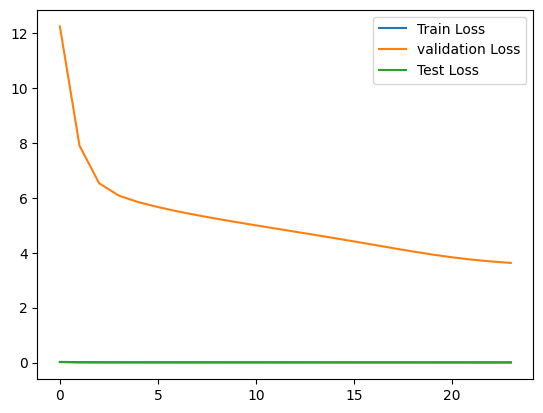

In [ ]:
# Plot the train and test losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='validation Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()

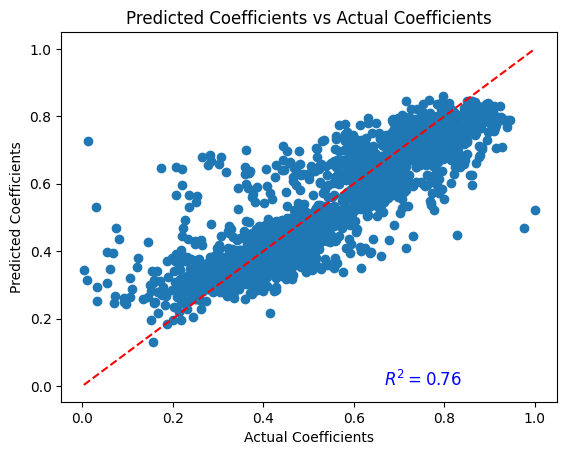

In [ ]:
# Convert output data from tensors to numpy
test_outputs_np = test_outputs.numpy()


# Flatten the denormalized test predictions and actual outputs
test_predictions_flat = test_predictions.flatten()
test_outputs_flat = test_outputs_np.flatten()

# r2 score for predicted & actual 2nd order coefficients
r2_coef = r2_score(test_outputs_flat, test_predictions_flat)

plt.scatter(test_outputs_flat, test_predictions_flat)
plt.xlabel('Actual Coefficients')
plt.ylabel('Predicted Coefficients')
plt.title('Predicted Coefficients vs Actual Coefficients')

# Add a diagonal line to visualize a perfect match between actual and predicted values
min_val = min(test_outputs_flat.min(), test_predictions_flat.min())
max_val = max(test_outputs_flat.max(), test_predictions_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

# Add the r2 score to the plot
plt.text(max_val - (max_val - min_val) / 3, max_val - 1, r'$R^2 = {:.2f}$'.format(r2_coef), fontsize=12, color='blue')

plt.show()

In [ ]:
# Denormalization the predicted & actual coefficients dataset
test_predictions_denorm = scaler.inverse_transform(test_predictions.reshape(-1, test_predictions.shape[-1]))
test_predictions_denorm = np.reshape(test_predictions_denorm, test_predictions.shape)

test_outputs_np_denorm = scaler.inverse_transform(test_outputs_np.reshape(-1, test_outputs_np.shape[-1]))
test_outputs_np_denorm = np.reshape(test_outputs_np_denorm, test_outputs_np.shape)

In [ ]:
# Insert the identities (sample name, layer number & curve number) of the curves back into the datasets
test_predictions_denorm_labelled = np.concatenate((test_predictions_denorm, test_identity[:, np.newaxis]), axis=-1)
test_outputs_np_denorm_labelled = np.concatenate((test_outputs_np_denorm, test_identity[:, np.newaxis]), axis=-1)

print(test_predictions_denorm_labelled.shape)
print(test_outputs_np_denorm_labelled.shape)

(751, 1, 6)
(751, 1, 6)


In [ ]:
# Convert the arrays to float type
pred_coef = test_predictions_denorm_labelled[:, :, :3].astype(float)
test_outputs_coef = test_outputs_np_denorm_labelled[:, :, :3].astype(float)


# Curves Plotting

In [ ]:
class PlotGraph():
    def __init__(self, coeffs, point_chains, root_points_list, name, layer_number, colors=None):
        self.coeffs = coeffs
        self.point_chains = point_chains
        self.root_points_list = root_points_list
        self.name = name
        self.layer_number = layer_number
        self.colors = colors if colors else ['blue'] * len(coeffs)

    def plot_curve(self, ax, x1, x2, coeff, label=None, color='blue'):
        p = np.poly1d(coeff)
        xp = np.linspace(x1, x2, 50)
        ax.plot(xp, p(xp), '-', color=color, label=label)

    def plot_ax(self):
        fig, ax = plt.subplots(figsize=(10, 10))  # Increase the figure size
        for coeff_set, point_chain_set, root_points_set, color_set in zip(self.coeffs, self.point_chains, self.root_points_list, self.colors):
            for i in range(min(len(coeff_set), len(point_chain_set), len(root_points_set))):
                label = f"{self.name} {self.layer_number} Actual" if i == 0 and color_set == 'green' else f"{self.name} {self.layer_number} Predicted" if i == 0 and color_set == 'red' else None
                self.plot_curve(ax, point_chain_set[i], np.max(root_points_set[i]), coeff_set[i], label=label, color=color_set)
        ax = plt.gca()
        ax.axvline(0)
        ax.axhline(0)
        ax.set_aspect('equal', adjustable='box')

        # Move the legend outside the plot to the right
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0)
                
        plt.show()

def get_plot_graph_without_points(coeff, point_chain, root_points, name, layer_number):
    plt = PlotGraph(coeff, point_chain, root_points, name, layer_number)
    plt.plot_ax()     

In [ ]:
def calibrate_x_position(x,y):
    coefficient=np.polyfit(x, y, 2,full=False)
    x_offset = np.roots(np.poly1d(coefficient).deriv())[0]
    return x_offset

In [ ]:
# Dataframe to store the actual vs predicted height & waivness value for each curves
shape_df = pd.DataFrame(columns=['sample_name', 'layer_num', 'curve_num', 'actual_height', 'predicted_height', 'actual_waviness', 'predicted_waviness'])

unique_sample_numbers = np.unique(test_predictions_denorm_labelled[:, 0, 3])
unique_layer_numbers = np.unique(test_predictions_denorm_labelled[:, 0, 4])

for sample_number in unique_sample_numbers:
    for layer_number in unique_layer_numbers:
        sample_mask_pred = test_predictions_denorm_labelled[:, 0, 3] == sample_number
        layer_mask_pred = test_predictions_denorm_labelled[:, 0, 4] == layer_number
        mask_pred = np.logical_and(sample_mask_pred, layer_mask_pred)

        sample_mask_act = test_outputs_np_denorm_labelled[:, 0, 3] == sample_number
        layer_mask_act = test_outputs_np_denorm_labelled[:, 0, 4] == layer_number
        mask_act = np.logical_and(sample_mask_act, layer_mask_act)

        if np.any(mask_pred) or np.any(mask_act):
            coef_pred = []
            root_points_pred = []
            cross_points_pred = []
            point_chain_pred = []
            coef_act = []
            root_points_act = []
            cross_points_act = []
            point_chain_act = []
            hatch_spacing = process_parameters.loc[sample_number, 'Hatching Spacing']
            x_range = np.arange(-10, 11)

            if np.any(mask_pred):
                test_filtered_pred = test_predictions_denorm_labelled[mask_pred]
                pred_coef_filtered = pred_coef[mask_pred]

                for i in range(len(test_filtered_pred)):
                    try:
                        xy_offset = hatch_spacing * int(test_filtered_pred[i,0,5])
                        a, b, c = pred_coef_filtered[i][0]
                        y_vals = a * x_range ** 2 + b * x_range + c
                        points = np.stack((x_range, y_vals), axis=-1)
                        coefficient = np.polyfit(points[:, 0:1].flatten()+xy_offset, points[:, 1:2].flatten(), 2, full=False)
                        p = np.poly1d(coefficient)
                        roots = np.roots(coefficient)
                        root_points_pred.append(roots)
                        coef_pred.append(coefficient)
                        if i != 0:
                            intersect_point = np.roots(coef_pred[i - 1] - coef_pred[i])
                            intersect_point = intersect_point[p(intersect_point) > 0]
                            cross_points_pred.append(np.max(intersect_point[(intersect_point >= np.min(root_points_pred[i-1])) & (intersect_point <= np.max(root_points_pred[i-1]))]))
                    except (ValueError, IndexError) as e:
                        print(f"Error occurred for Sample Number: {sample_number}, Layer Number: {layer_number}")
                        continue

                point_chain_pred = np.concatenate(([np.min(root_points_pred[0])], cross_points_pred, [np.max(root_points_pred[-1])]))
                #plt_pred = PlotGraph(coef_pred, point_chain_pred, root_points_pred, sample_number, layer_number, color='red')
            
            if np.any(mask_act):
                test_filtered_act = test_outputs_np_denorm_labelled[mask_act]
                act_coef_filtered = test_outputs_coef[mask_act]

                for i in range(len(test_filtered_act)):
                    try:
                        xy_offset = hatch_spacing * int(test_filtered_act[i,0,5])
                        a, b, c = act_coef_filtered[i][0]
                        y_vals = a * x_range ** 2 + b * x_range + c
                        points = np.stack((x_range, y_vals), axis=-1)
                        coefficient = np.polyfit(points[:, 0:1].flatten()+xy_offset, points[:, 1:2].flatten(), 2, full=False)
                        if np.any(~np.isfinite(coefficient)):
                            raise ValueError("Invalid coefficient array")
                        p = np.poly1d(coefficient)
                        roots = np.roots(coefficient)
                        root_points_act.append(roots)
                        coef_act.append(coefficient)
                        if i != 0:
                            intersect_point = np.roots(coef_act[i - 1] - coef_act[i])
                            intersect_point = intersect_point[p(intersect_point) > 0]
                            cross_points_act.append(np.max(intersect_point[(intersect_point >= np.min(root_points_act[i-1])) & (intersect_point <= np.max(root_points_act[i-1]))]))
                    except (ValueError, IndexError) as e:
                        print(f"Error occurred for Sample Number: {sample_number}, Layer Number: {layer_number}")
                        continue

                point_chain_act = np.concatenate(([np.min(root_points_act[0])], cross_points_act, [np.max(root_points_act[-1])]))
                #plt_act = PlotGraph(coef_act, point_chain_act, root_points_act, sample_number, layer_number, color='green')
            
            if np.any(mask_act) and np.any(mask_pred):
              heights_pred = []
              heights_act = []
              waviness_pred = []
              waviness_act = []

              for i, (coef_p, coef_a) in enumerate(zip(coef_pred, coef_act)):
                  p_pred = np.poly1d(coef_p)
                  p_act = np.poly1d(coef_a)

                  # Obtain height        
                  max_height_pred = p_pred(np.roots(p_pred.deriv()))[0]
                  max_height_act = p_act(np.roots(p_act.deriv()))[0]

                  # Obtain waviness 
                  if i != 0:
                      intersect_point_pred = np.roots(coef_pred[i - 1] - coef_pred[i])
                      intersect_point_pred = intersect_point_pred[p_pred(intersect_point_pred) > 0]
                      cross_point_pred = np.max(intersect_point_pred[(intersect_point_pred >= np.min(root_points_pred[i-1])) & (intersect_point_pred <= np.max(root_points_pred[i-1]))])

                      intersect_point_act = np.roots(coef_act[i - 1] - coef_act[i])
                      intersect_point_act = intersect_point_act[p_act(intersect_point_act) > 0]
                      cross_point_act = np.max(intersect_point_act[(intersect_point_act >= np.min(root_points_act[i-1])) & (intersect_point_act <= np.max(root_points_act[i-1]))])

                      waviness_pred.append(max_height_pred - p_pred(cross_point_pred))
                      waviness_act.append(max_height_act - p_act(cross_point_act))

                  heights_pred.append(max_height_pred)
                  heights_act.append(max_height_act)

                  row_data = pd.DataFrame([{
                      'sample_name': sample_number,
                      'layer_num': layer_number,
                      'curve_num': i,
                      'predicted_height': max_height_pred,
                      'actual_height': max_height_act,
                      'predicted_waviness': waviness_pred[-1] if i != 0 else 0,
                      'actual_waviness': waviness_act[-1] if i != 0 else 0
                  }])

                  shape_df = pd.concat([shape_df, row_data], ignore_index=True)

In [ ]:
shape_df

sample_name layer_num curve_num  actual_height  predicted_height  \
0           E10        L5         0     560.330288        592.944022   
1           E10        L5         1     574.302203        610.573171   
2           E10        L5         2     612.298940        553.637758   
3           E10        L5         3     592.218912        577.501833   
4           E10        L6         0     470.896330        588.296989   
..          ...       ...       ...            ...               ...   
746          E9        L6         5    1015.783557        918.615622   
747          E9        L6         6    1036.681136        933.251864   
748          E9        L6         7    1019.671729        937.925971   
749          E9        L6         8    1043.062471        925.495092   
750          E9        L6         9     967.919619        927.983451   

    actual_waviness predicted_waviness  
0                 0                  0  
1        162.942852         351.948873  
2        315.308549          239.02583  
3        145.783428         367.060626  
4                 0                  0  
..              ...                ...  
746      215.563195          165.69754  
747      220.937767         167.653791  
748      152.387916          171.69019  
749      215.643342         132.441432  
750        69.88919         173.085868  

[751 rows x 7 columns]

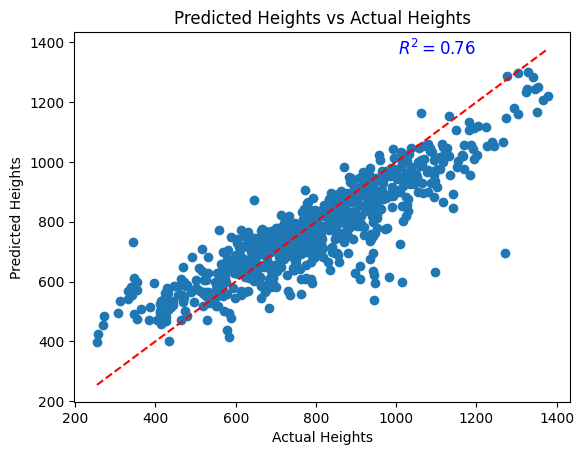

In [ ]:
# r2 score for predicted & actual heights

actual_heights = shape_df['actual_height'].values
predicted_heights = shape_df['predicted_height'].values

r2_heights = r2_score(actual_heights, predicted_heights)

plt.scatter(actual_heights, predicted_heights)
plt.xlabel('Actual Heights')
plt.ylabel('Predicted Heights')
plt.title('Predicted Heights vs Actual Heights')

# Add a diagonal line to visualize a perfect match between actual and predicted values
min_val = min(actual_heights.min(), predicted_heights.min())
max_val = max(actual_heights.max(), predicted_heights.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

# Add the r2 score to the plot
plt.text(max_val - (max_val - min_val) / 3, max_val - 20, r'$R^2 = {:.2f}$'.format(r2_heights), fontsize=12, color='blue')

plt.show()

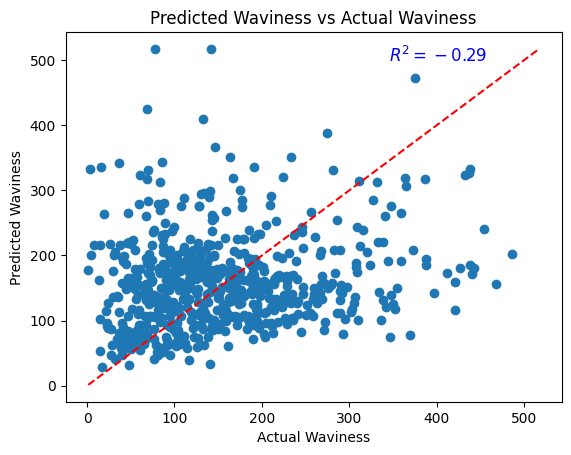

In [ ]:
# Exclude rows for every first curve with 0 waviness from the r2 calculation
filtered_shape_df = shape_df[shape_df['actual_waviness'] != 0]

# r2 score for predicted & actual waviness

actual_waviness = filtered_shape_df['actual_waviness'].values
predicted_waviness = filtered_shape_df['predicted_waviness'].values

r2_waviness = r2_score(actual_waviness, predicted_waviness)

plt.scatter(actual_waviness, predicted_waviness)
plt.xlabel('Actual Waviness')
plt.ylabel('Predicted Waviness')
plt.title('Predicted Waviness vs Actual Waviness')

# Add a diagonal line to visualize a perfect match between actual and predicted values
min_val = min(actual_waviness.min(), predicted_waviness.min())
max_val = max(actual_waviness.max(), predicted_waviness.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

# Add the r2 score to the plot
plt.text(max_val - (max_val - min_val) / 3, max_val - 20, r'$R^2 = {:.2f}$'.format(r2_waviness), fontsize=12, color='blue')

plt.show()

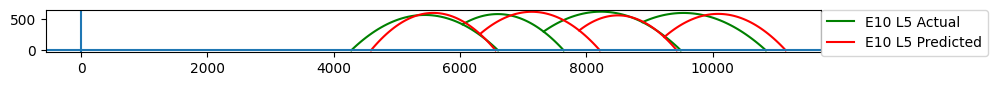

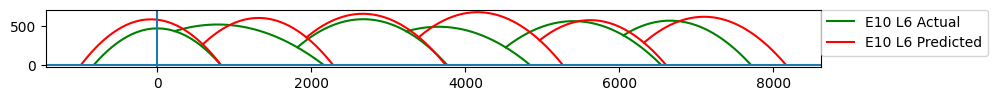

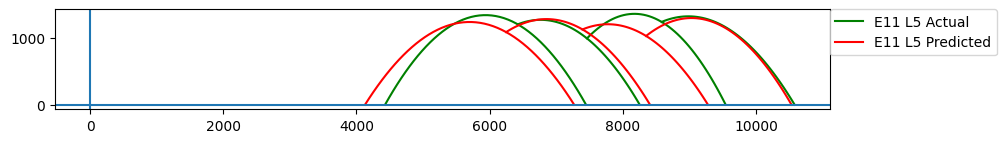

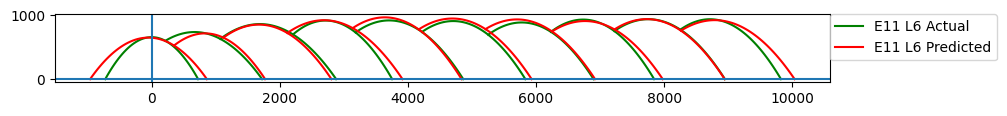

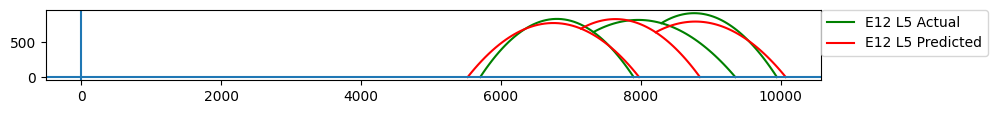

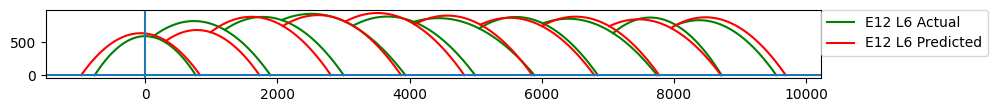

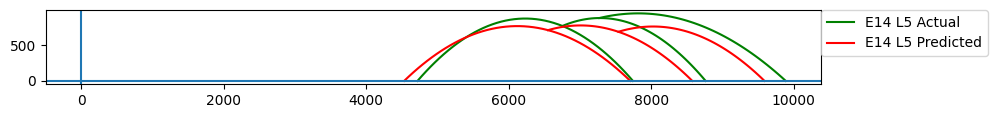

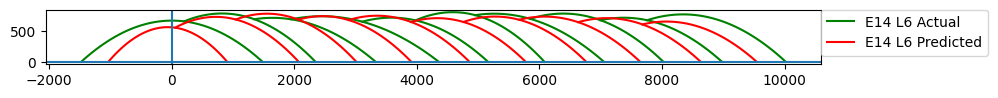

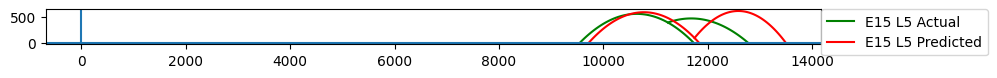

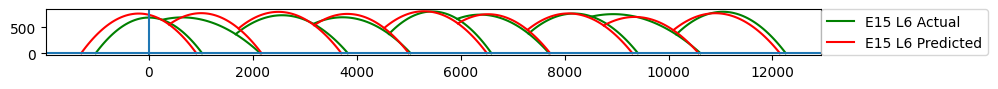

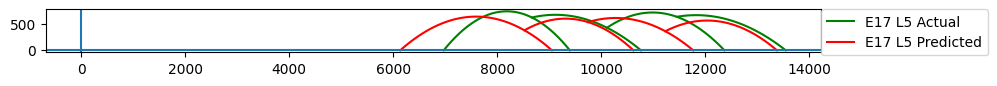

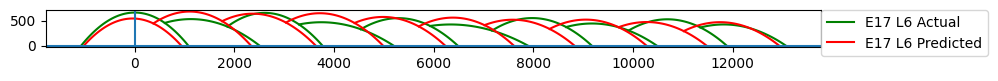

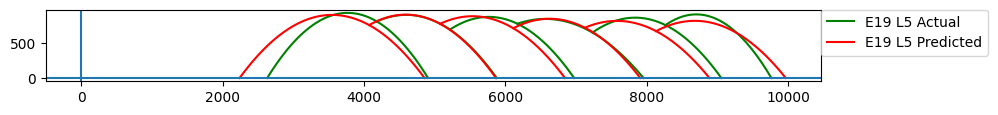

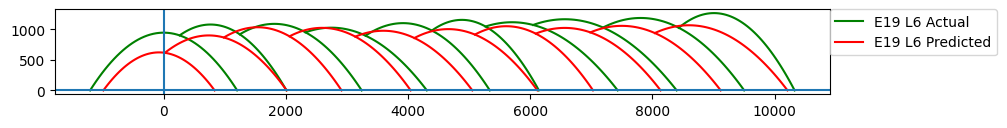

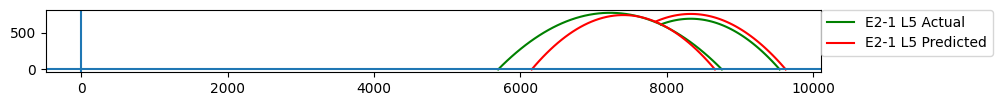

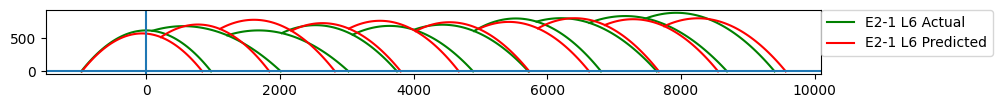

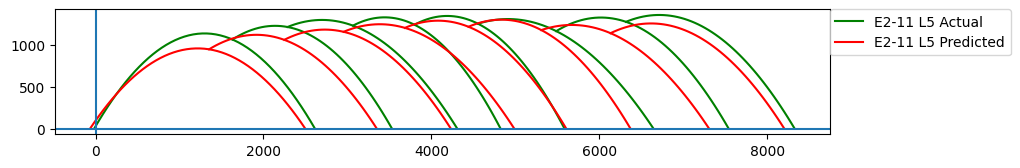

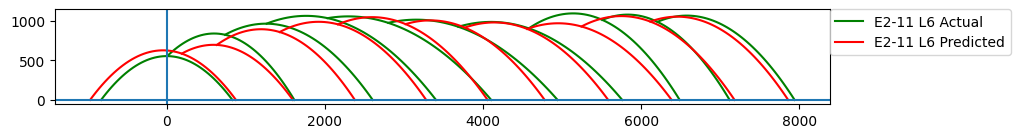

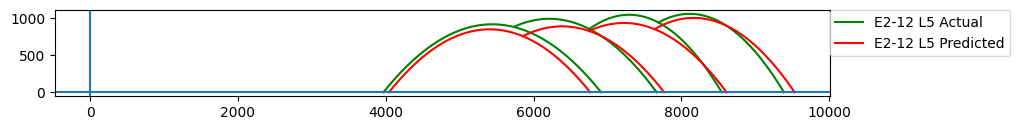

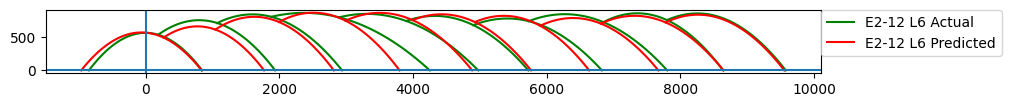

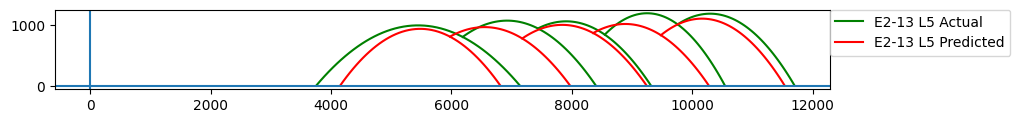

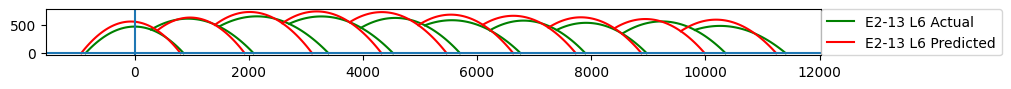

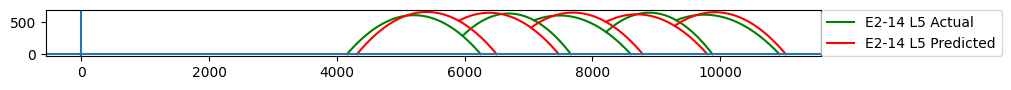

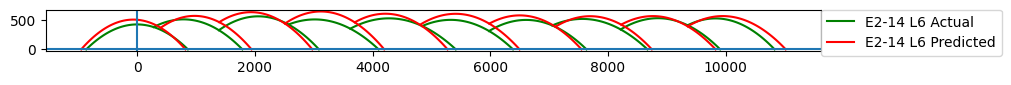

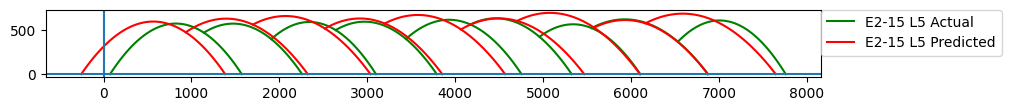

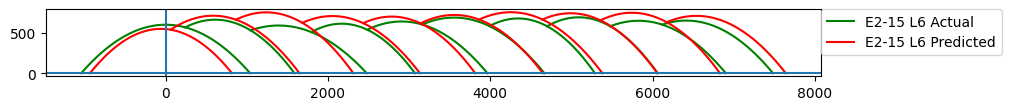

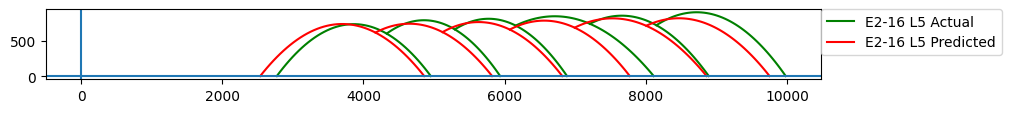

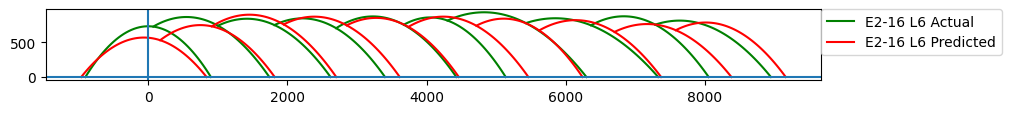

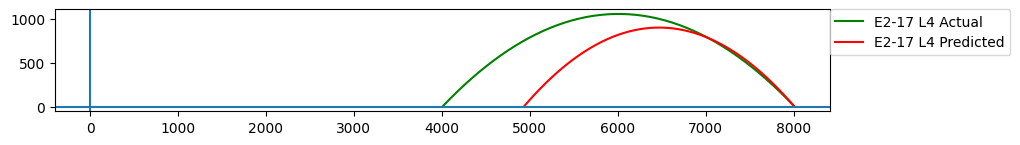

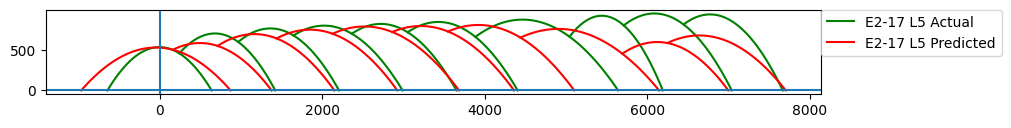

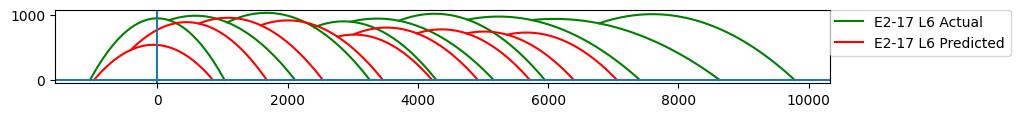

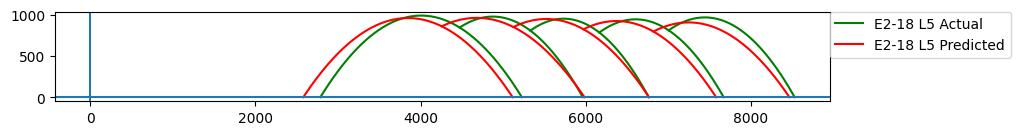

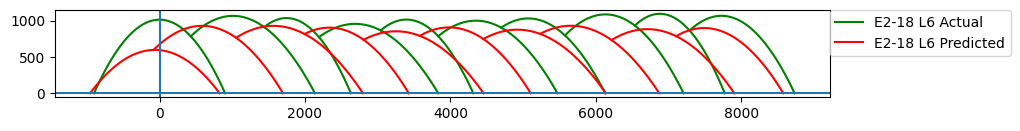

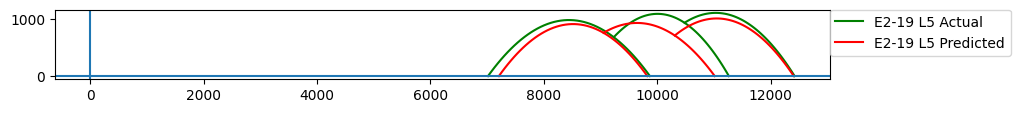

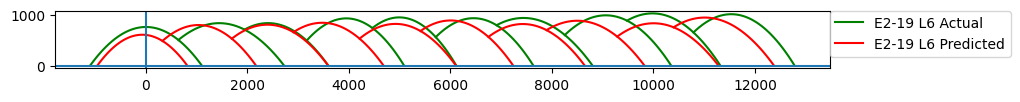

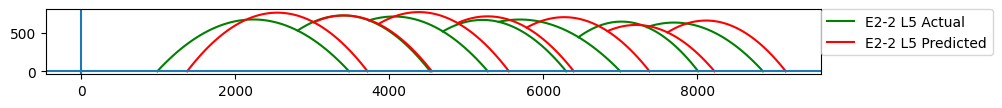

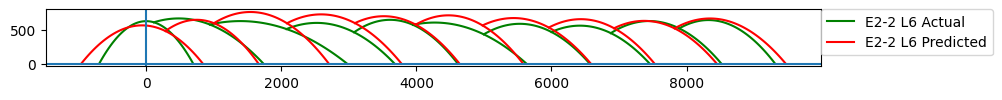

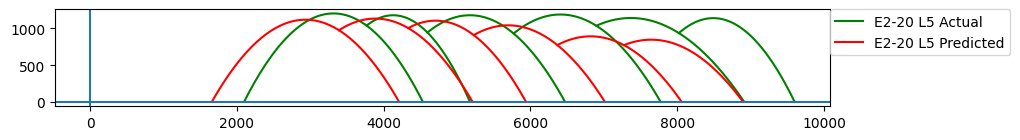

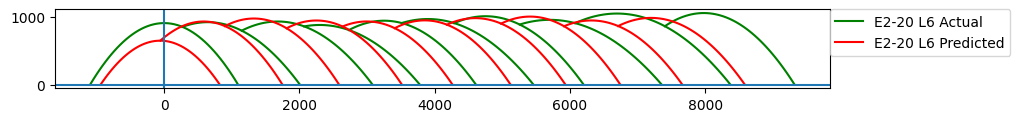

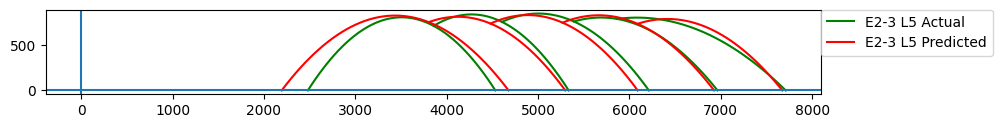

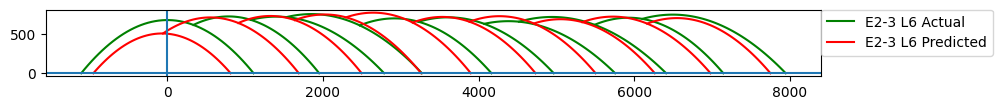

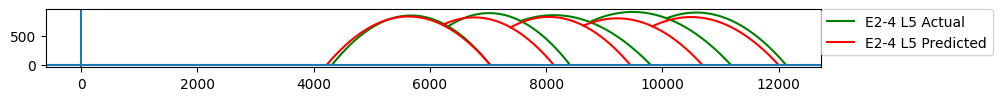

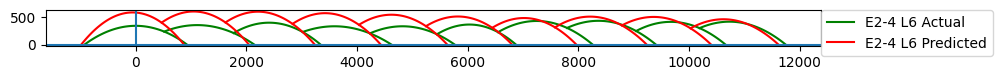

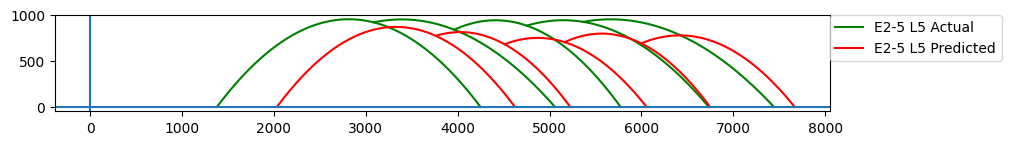

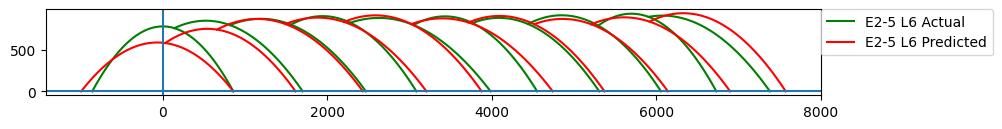

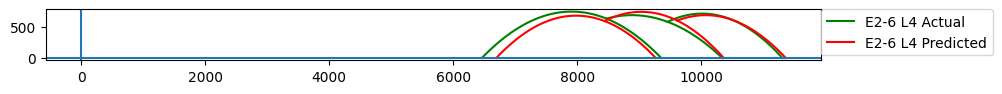

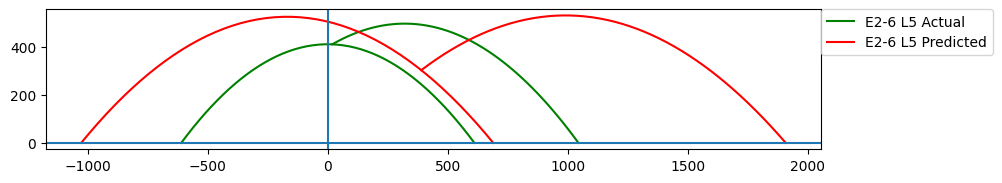

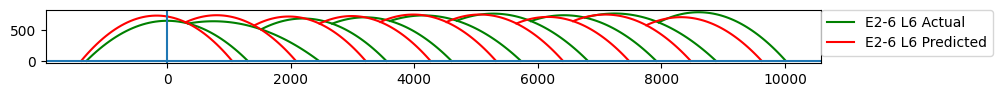

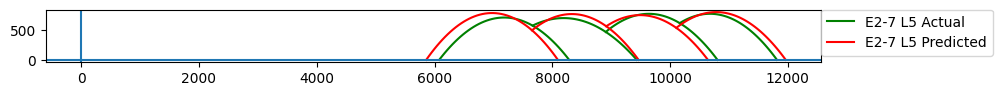

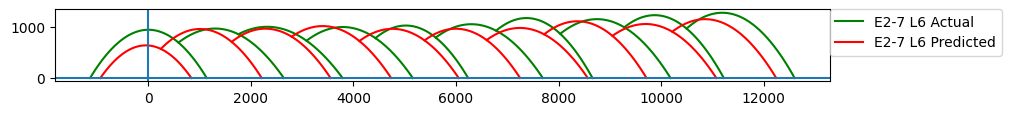

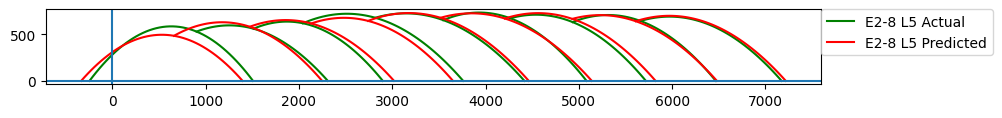

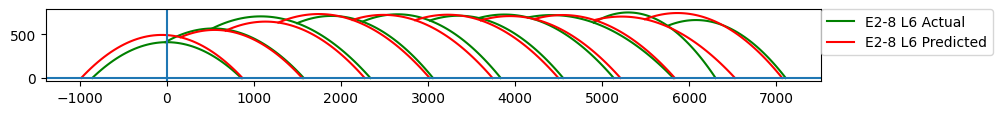

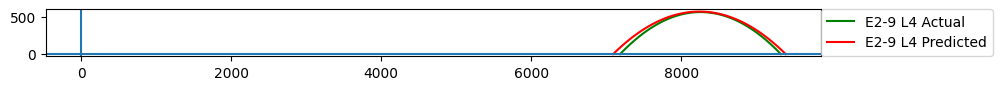

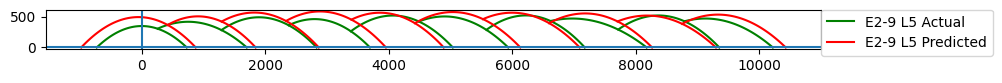

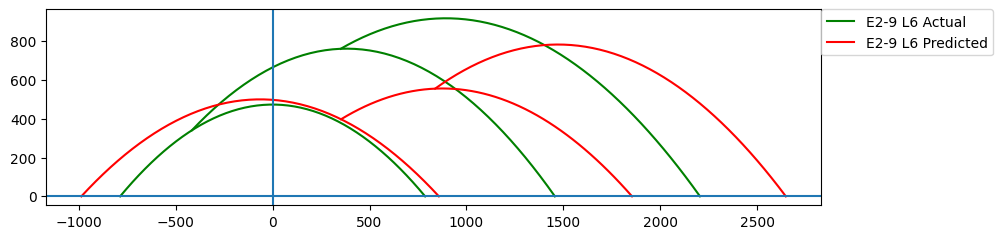

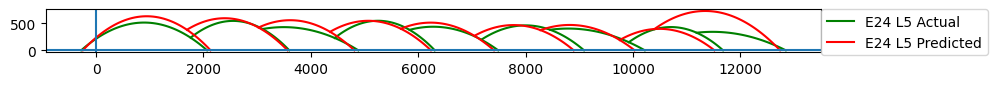

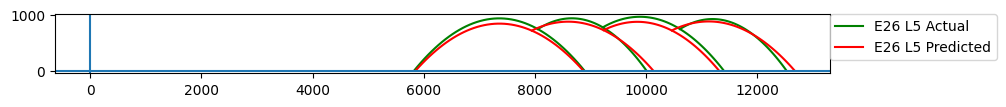

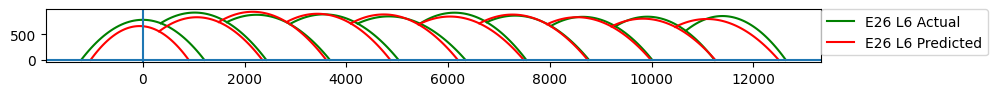

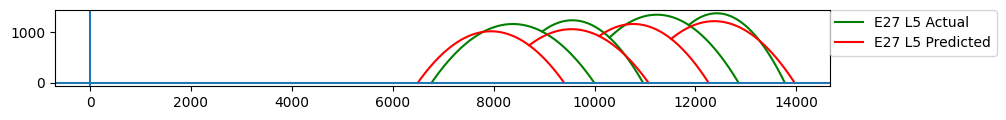

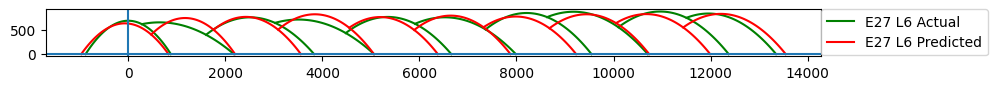

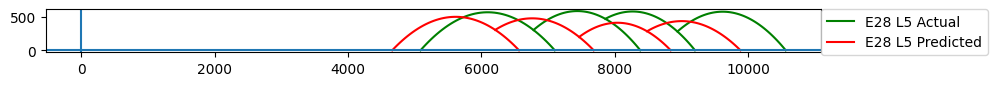

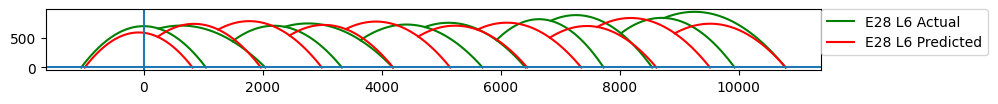

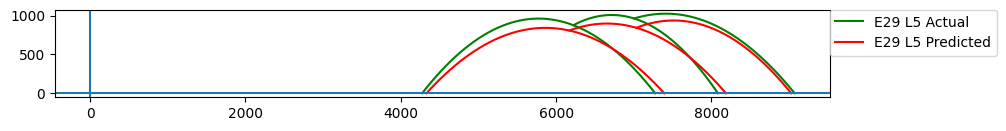

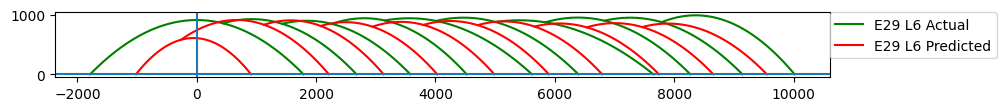

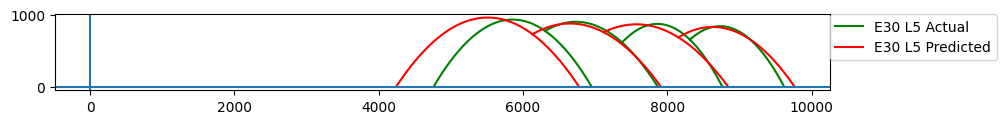

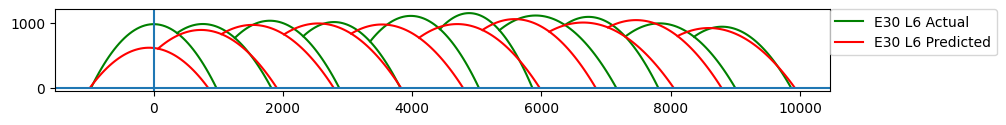

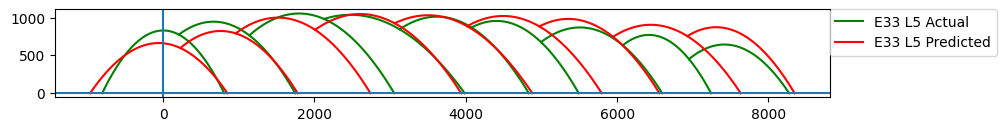

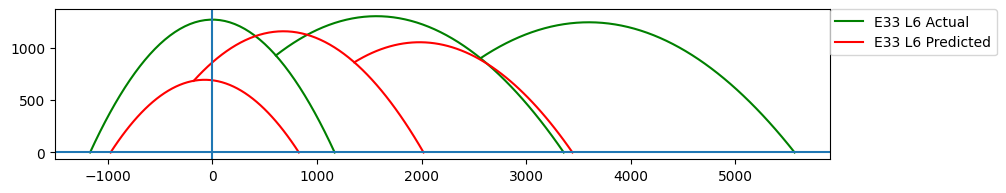

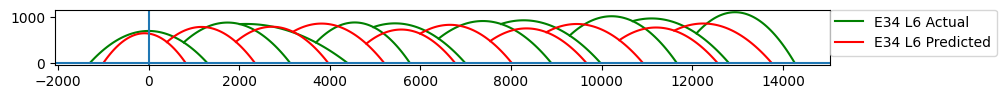

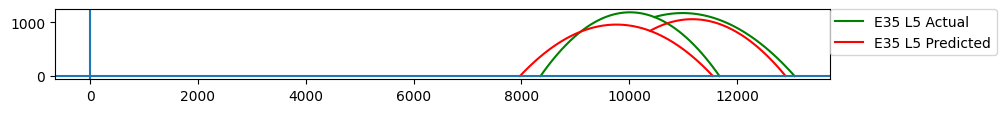

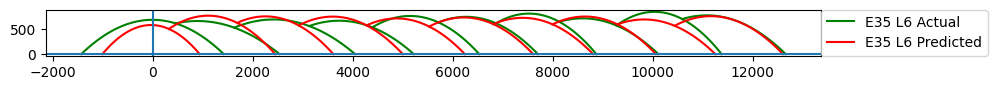

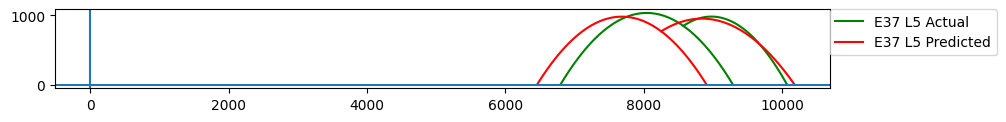

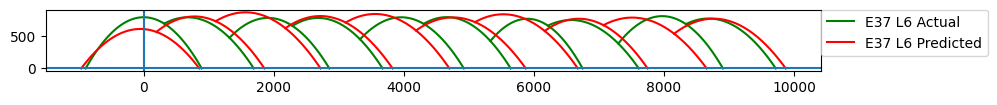

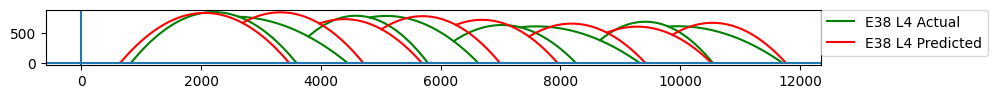

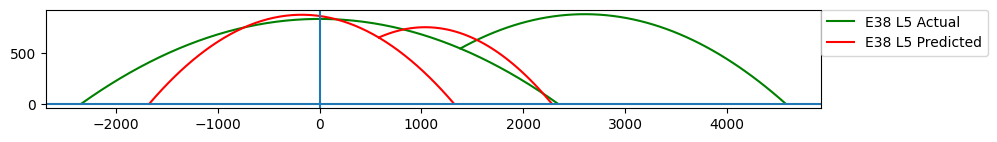

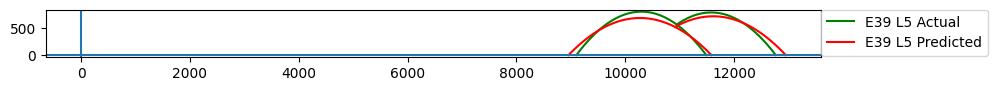

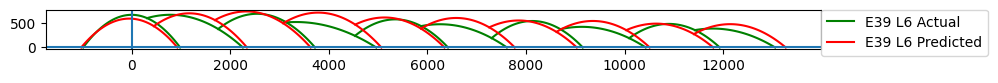

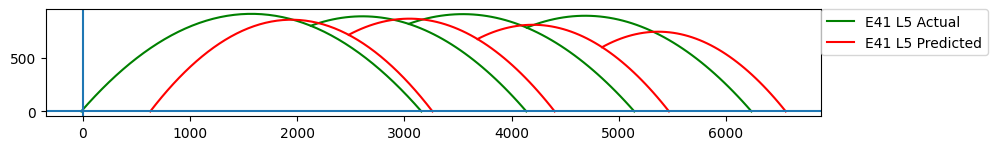

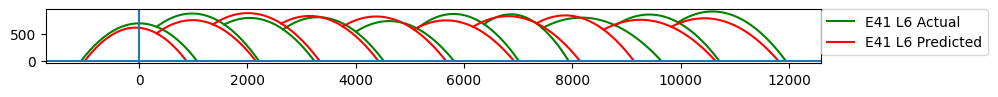

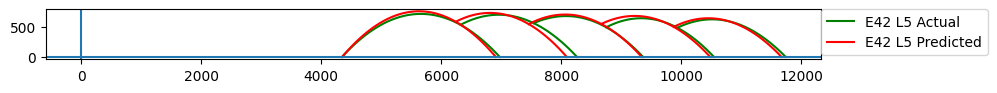

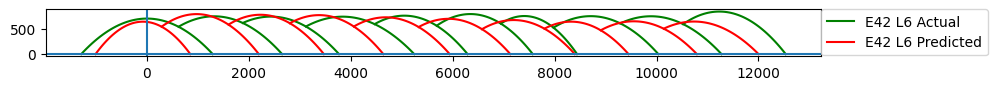

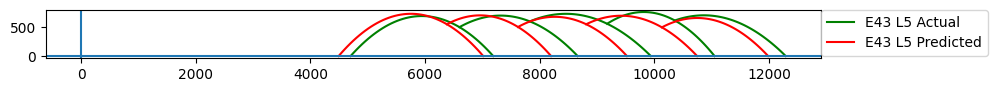

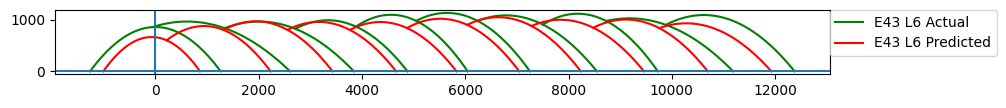

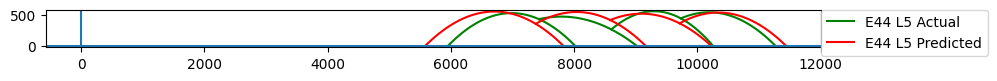

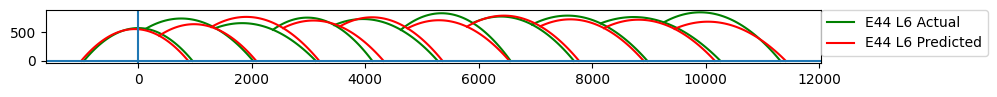

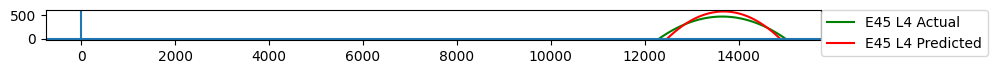

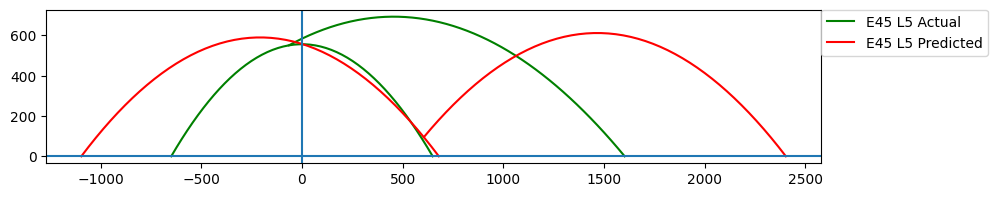

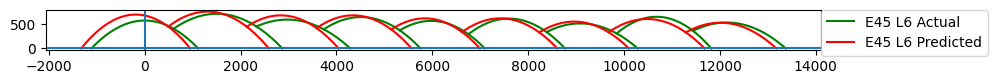

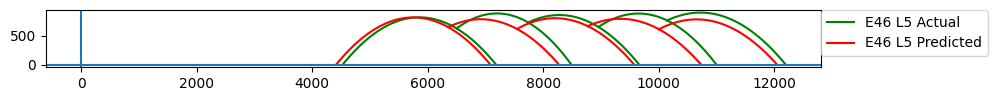

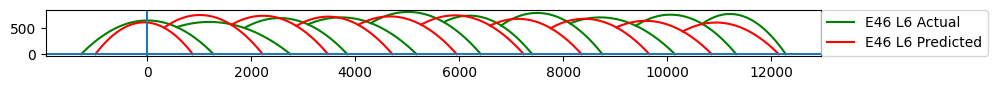

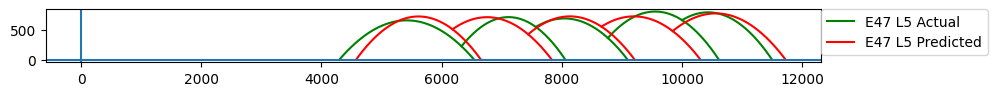

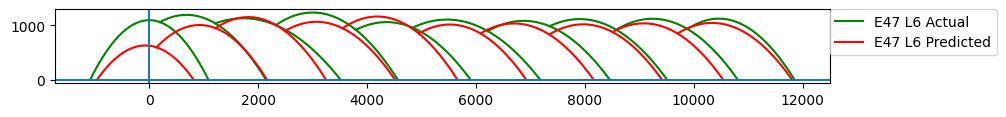

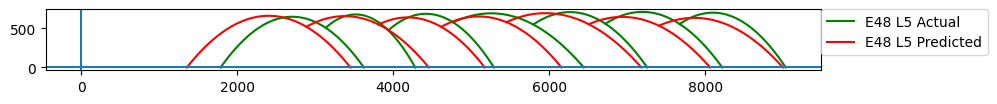

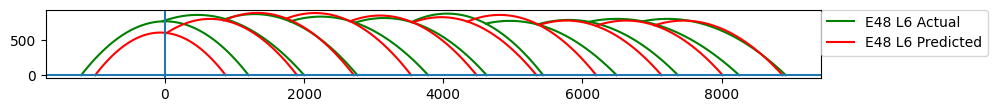

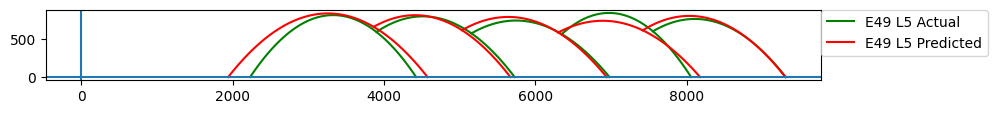

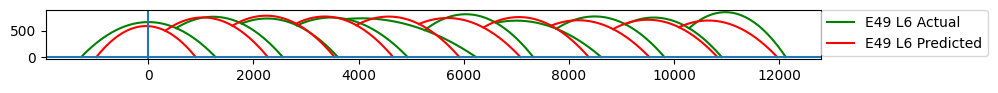

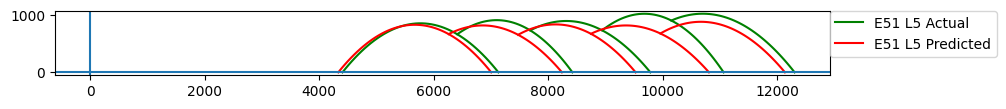

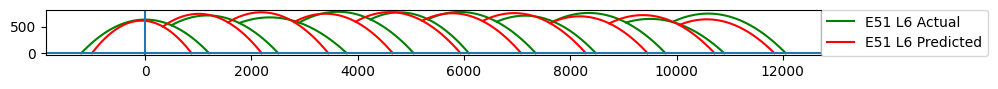

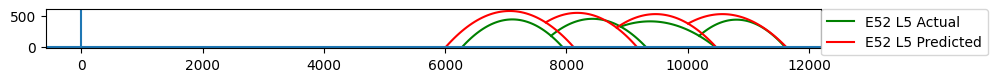

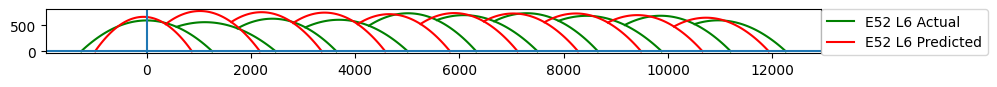

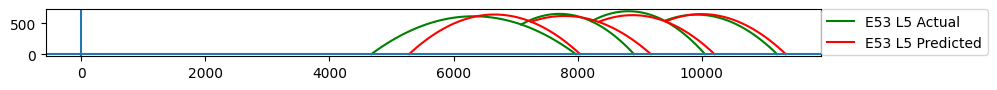

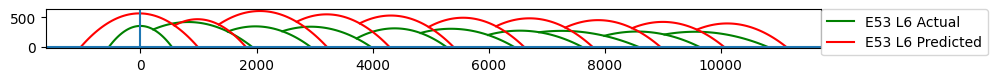

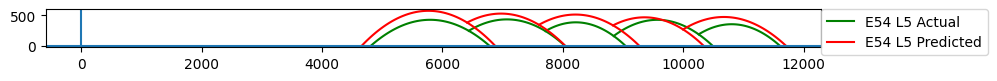

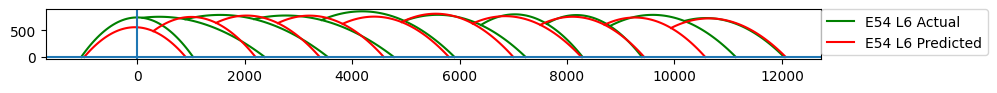

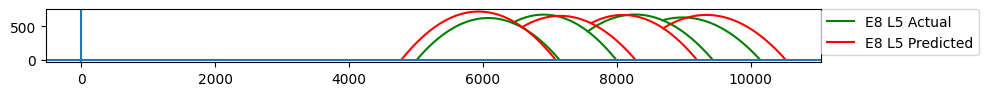

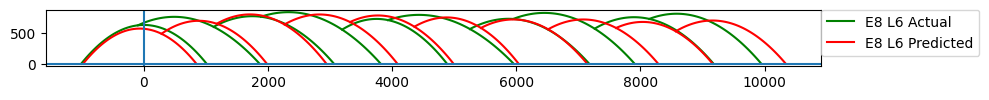

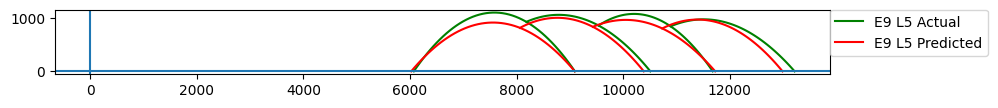

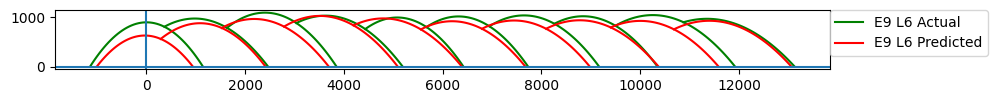

In [ ]:
unique_sample_numbers = np.unique(test_predictions_denorm_labelled[:, 0, 3])
unique_layer_numbers = np.unique(test_predictions_denorm_labelled[:, 0, 4])

for sample_number in unique_sample_numbers:
    for layer_number in unique_layer_numbers:
        sample_mask_pred = test_predictions_denorm_labelled[:, 0, 3] == sample_number
        layer_mask_pred = test_predictions_denorm_labelled[:, 0, 4] == layer_number
        mask_pred = np.logical_and(sample_mask_pred, layer_mask_pred)

        sample_mask_act = test_outputs_np_denorm_labelled[:, 0, 3] == sample_number
        layer_mask_act = test_outputs_np_denorm_labelled[:, 0, 4] == layer_number
        mask_act = np.logical_and(sample_mask_act, layer_mask_act)

        if np.any(mask_pred) or np.any(mask_act):
            coef_pred = []
            root_points_pred = []
            cross_points_pred = []
            point_chain_pred = []
            coef_act = []
            root_points_act = []
            cross_points_act = []
            point_chain_act = []
            hatch_spacing = process_parameters.loc[sample_number, 'Hatching Spacing']
            x_range = np.arange(-10, 11)

            if np.any(mask_pred):
                test_filtered_pred = test_predictions_denorm_labelled[mask_pred]
                pred_coef_filtered = pred_coef[mask_pred]

                for i in range(len(test_filtered_pred)):
                    try:
                        xy_offset = hatch_spacing * int(test_filtered_pred[i,0,5])
                        a, b, c = pred_coef_filtered[i][0]
                        y_vals = a * x_range ** 2 + b * x_range + c
                        points = np.stack((x_range, y_vals), axis=-1)
                        coefficient = np.polyfit(points[:, 0:1].flatten()+xy_offset, points[:, 1:2].flatten(), 2, full=False)
                        p = np.poly1d(coefficient)
                        roots = np.roots(coefficient)
                        root_points_pred.append(roots)
                        coef_pred.append(coefficient)
                        if i != 0:
                            intersect_point = np.roots(coef_pred[i - 1] - coef_pred[i])
                            intersect_point = intersect_point[p(intersect_point) > 0]
                            cross_points_pred.append(np.max(intersect_point[(intersect_point >= np.min(root_points_pred[i-1])) & (intersect_point <= np.max(root_points_pred[i-1]))]))
                    except (ValueError, IndexError) as e:
                        print(f"Error occurred for Sample Number: {sample_number}, Layer Number: {layer_number}")
                        continue

                point_chain_pred = np.concatenate(([np.min(root_points_pred[0])], cross_points_pred, [np.max(root_points_pred[-1])]))
                #plt_pred = PlotGraph(coef_pred, point_chain_pred, root_points_pred, sample_number, layer_number, color='red')
            
            if np.any(mask_act):
                test_filtered_act = test_outputs_np_denorm_labelled[mask_act]
                act_coef_filtered = test_outputs_coef[mask_act]

                for i in range(len(test_filtered_act)):
                    try:
                        xy_offset = hatch_spacing * int(test_filtered_act[i,0,5])
                        a, b, c = act_coef_filtered[i][0]
                        y_vals = a * x_range ** 2 + b * x_range + c
                        points = np.stack((x_range, y_vals), axis=-1)
                        coefficient = np.polyfit(points[:, 0:1].flatten()+xy_offset, points[:, 1:2].flatten(), 2, full=False)
                        if np.any(~np.isfinite(coefficient)):
                            raise ValueError("Invalid coefficient array")
                        p = np.poly1d(coefficient)
                        roots = np.roots(coefficient)
                        root_points_act.append(roots)
                        coef_act.append(coefficient)
                        if i != 0:
                            intersect_point = np.roots(coef_act[i - 1] - coef_act[i])
                            intersect_point = intersect_point[p(intersect_point) > 0]
                            cross_points_act.append(np.max(intersect_point[(intersect_point >= np.min(root_points_act[i-1])) & (intersect_point <= np.max(root_points_act[i-1]))]))
                    except (ValueError, IndexError) as e:
                        print(f"Error occurred for Sample Number: {sample_number}, Layer Number: {layer_number}")
                        continue

                point_chain_act = np.concatenate(([np.min(root_points_act[0])], cross_points_act, [np.max(root_points_act[-1])]))
                #plt_act = PlotGraph(coef_act, point_chain_act, root_points_act, sample_number, layer_number, color='green')
            
            if np.any(mask_act) and np.any(mask_pred):
                  plt_combined = PlotGraph([coef_act, coef_pred], [point_chain_act, point_chain_pred], [root_points_act, root_points_pred],
                                          sample_number, layer_number, colors=['green', 'red'])
                  plt_combined.plot_ax()

# Prediction of Geometry with Different Laser Power & Hatch Spacing Value

In [ ]:
new_df

Laser power  Scanning speed  Powder mass flow rate  Hatching Spacing  \
1561       1300.0          1800.0                 12.734               0.0   
1562       1300.0          1800.0                 12.734            1178.0   
1563       1300.0          1800.0                 12.734            2356.0   
1564       1300.0          1800.0                 12.734            3534.0   
1565       1300.0          1800.0                 12.734            4712.0   
1566       1300.0          1800.0                 12.734            5890.0   
1567       1300.0          1800.0                 12.734            7068.0   
1568       1300.0          1800.0                 12.734            8246.0   
1569       1300.0          1800.0                 12.734            9424.0   
1570       1300.0          1800.0                 12.734           10602.0   

      Z-incremental value         a             b           c sample_name  \
1561               2850.0  0.000000  0.000000e+00    0.000000         E44   
1562               2850.0 -0.000631  2.515848e-16  577.552289         E44   
1563               2850.0 -0.000464 -3.904881e-01  664.115396         E44   
1564               2850.0 -0.000395 -4.140895e-01  555.840129         E44   
1565               2850.0 -0.000581 -6.440941e-01  583.145645         E44   
1566               2850.0 -0.000423 -6.383625e-01  496.049283         E44   
1567               2850.0 -0.000567 -6.179507e-01  670.434770         E44   
1568               2850.0 -0.000470 -6.380205e-01  564.269149         E44   
1569               2850.0 -0.000403 -5.487860e-01  610.311191         E44   
1570               2850.0 -0.000330 -4.584509e-01  612.778849         E44   

     layer_num  
1561        L6  
1562        L6  
1563        L6  
1564        L6  
1565        L6  
1566        L6  
1567        L6  
1568        L6  
1569        L6  
1570        L6

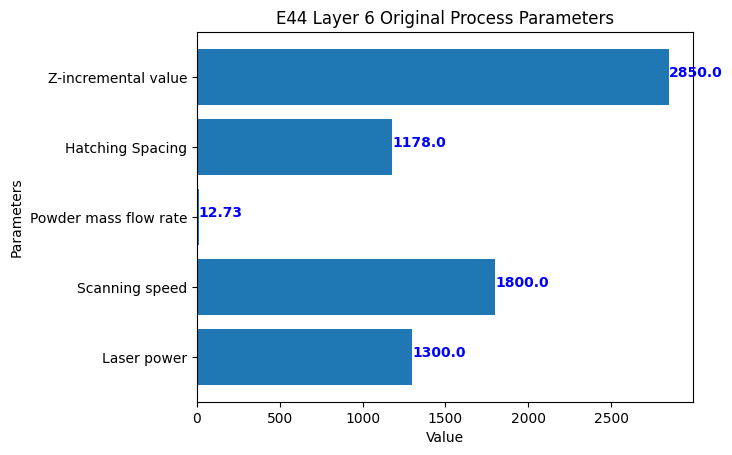

In [ ]:
# Select the row you want to plot
row = new_df.iloc[1]

# Extract the values of the process parameters
process_params = ['Laser power', 'Scanning speed', 'Powder mass flow rate', 'Hatching Spacing', 'Z-incremental value']
values = row[process_params]

# Create a horizontal bar chart
plt.barh(process_params, values)

# Add the values to the chart
for i, v in enumerate(values):
    plt.text(v, i, str(round(v,2)), color='blue', fontweight='bold')

# Set the title and labels
plt.title('E44 Layer 6 Original Process Parameters')
plt.xlabel('Value')
plt.ylabel('Parameters')

# Display the chart
plt.show()

In [ ]:
new_df["Powder mass flow rate"] += 7.266
new_df["Laser power"] += 100
new_df

Laser power  Scanning speed  Powder mass flow rate  Hatching Spacing  \
1561         1400          1800.0                   20.0               0.0   
1562         1400          1800.0                   20.0            1178.0   
1563         1400          1800.0                   20.0            2356.0   
1564         1400          1800.0                   20.0            3534.0   
1565         1400          1800.0                   20.0            4712.0   
1566         1400          1800.0                   20.0            5890.0   
1567         1400          1800.0                   20.0            7068.0   
1568         1400          1800.0                   20.0            8246.0   
1569         1400          1800.0                   20.0            9424.0   
1570         1400          1800.0                   20.0           10602.0   

      Z-incremental value         a             b           c  
1561               2850.0  0.000000  0.000000e+00    0.000000  
1562               2850.0 -0.000631  2.515848e-16  577.552289  
1563               2850.0 -0.000464 -3.904881e-01  664.115396  
1564               2850.0 -0.000395 -4.140895e-01  555.840129  
1565               2850.0 -0.000581 -6.440941e-01  583.145645  
1566               2850.0 -0.000423 -6.383625e-01  496.049283  
1567               2850.0 -0.000567 -6.179507e-01  670.434770  
1568               2850.0 -0.000470 -6.380205e-01  564.269149  
1569               2850.0 -0.000403 -5.487860e-01  610.311191  
1570               2850.0 -0.000330 -4.584509e-01  612.778849

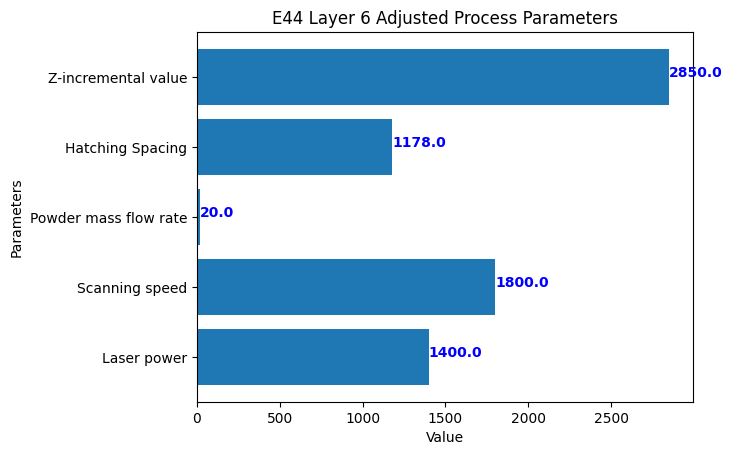

In [ ]:
# Select the row you want to plot
row = new_df.iloc[1]

# Extract the values of the process parameters
process_params = ['Laser power', 'Scanning speed', 'Powder mass flow rate', 'Hatching Spacing', 'Z-incremental value']
values = row[process_params]

# Create a horizontal bar chart
plt.barh(process_params, values)

# Add the values to the chart
for i, v in enumerate(values):
    plt.text(v, i, str(round(v,2)), color='blue', fontweight='bold')

# Set the title and labels
plt.title('E44 Layer 6 Adjusted Process Parameters')
plt.xlabel('Value')
plt.ylabel('Parameters')

# Display the chart
plt.show()

In [ ]:
new_test_identity = new_df[['sample_name','layer_num']]

KeyError: ignored

In [ ]:
# Get the number of rows in the dataframe
num_rows = new_test_identity.shape[0]

# Create a new column 'curve_num' with values from 0 to the last row number
new_test_identity['curve_num'] = range(num_rows)

new_test_identity

<ipython-input-126-ede5847e94c1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_test_identity['curve_num'] = range(num_rows)


sample_name layer_num  curve_num
1561         E44        L6          0
1562         E44        L6          1
1563         E44        L6          2
1564         E44        L6          3
1565         E44        L6          4
1566         E44        L6          5
1567         E44        L6          6
1568         E44        L6          7
1569         E44        L6          8
1570         E44        L6          9

In [ ]:
new_df=new_df.drop(['sample_name','layer_num'],axis=1)
new_df

KeyError: ignored

In [ ]:
new_df_norm = process_parameters_scaler.transform(new_df)

In [ ]:
# Convert the numpy array to a PyTorch tensor
new_df_tensor = torch.tensor(new_df_norm, dtype=torch.float32)

In [ ]:
new_df_tensor

tensor([[0.5959, 0.2139, 1.4129, 0.0000, 0.4918, 1.0000, 0.4634, 0.0000],
        [0.5959, 0.2139, 1.4129, 0.0553, 0.4918, 0.6176, 0.4634, 0.3762],
        [0.5959, 0.2139, 1.4129, 0.1106, 0.4918, 0.7187, 0.3547, 0.4326],
        [0.5959, 0.2139, 1.4129, 0.1660, 0.4918, 0.7609, 0.3481, 0.3621],
        [0.5959, 0.2139, 1.4129, 0.2213, 0.4918, 0.6480, 0.2841, 0.3799],
        [0.5959, 0.2139, 1.4129, 0.2766, 0.4918, 0.7434, 0.2857, 0.3231],
        [0.5959, 0.2139, 1.4129, 0.3319, 0.4918, 0.6566, 0.2914, 0.4367],
        [0.5959, 0.2139, 1.4129, 0.3872, 0.4918, 0.7153, 0.2858, 0.3676],
        [0.5959, 0.2139, 1.4129, 0.4426, 0.4918, 0.7555, 0.3106, 0.3976],
        [0.5959, 0.2139, 1.4129, 0.4979, 0.4918, 0.7998, 0.3358, 0.3992]])

In [ ]:
# Load the saved model
model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout)
model.load_state_dict(torch.load("lstm_model.pth"))

<All keys matched successfully>

In [ ]:
# Set the model to evaluation mode
model.eval()

# Pass the new input tensor through the model
with torch.no_grad():
    new_output_tensor = model(new_df_tensor.unsqueeze(1))

In [ ]:
# Convert the output tensor to a NumPy array
new_output_data = new_output_tensor.squeeze(1).numpy()
new_output_data

array([[0.57756793, 0.45198473, 0.41702792],
       [0.62120545, 0.41197735, 0.49319664],
       [0.66169006, 0.351266  , 0.53378475],
       [0.6658568 , 0.35419753, 0.48851055],
       [0.64279234, 0.30669937, 0.47926912],
       [0.66549635, 0.31789222, 0.44731826],
       [0.66443187, 0.31140417, 0.5033005 ],
       [0.6774316 , 0.31586388, 0.4559037 ],
       [0.6992684 , 0.33389485, 0.47204286],
       [0.71850485, 0.35368478, 0.46961796]], dtype=float32)

In [ ]:
new_output_data_denorm = scaler.inverse_transform(new_output_data)
# Reshape the array to shape (10, 1, 3)
arr_3d = new_output_data_denorm .reshape((10, 1, 3))

In [ ]:
# Assuming arr_3d is already defined
# Convert the new_test_identity DataFrame to a NumPy array and reshape it to the required dimensions
new_test_identity_np = new_test_identity.to_numpy().reshape(10, 1, -1)

# Concatenate arr_3d and new_test_identity_np along the second axis
final_arr = np.concatenate((arr_3d.astype('object'), new_test_identity_np), axis=2)
final_arr

array([[[-0.0007297672564163804, -0.0023272919934242964,
         641.1027221679688, 'E44', 'L6', 0]],

       [[-0.0006602503126487136, -0.14948755502700806,
         757.9119262695312, 'E44', 'L6', 1]],

       [[-0.0005957561079412699, -0.37280383706092834,
         820.1561889648438, 'E44', 'L6', 2]],

       [[-0.0005891182809136808, -0.36202067136764526, 750.7255859375,
         'E44', 'L6', 3]],

       [[-0.000625861226581037, -0.5367345213890076, 736.5532836914062,
         'E44', 'L6', 4]],

       [[-0.0005896924994885921, -0.4955635070800781, 687.5547485351562,
         'E44', 'L6', 5]],

       [[-0.0005913882632739842, -0.5194286704063416, 773.40673828125,
         'E44', 'L6', 6]],

       [[-0.000570678967051208, -0.5030243992805481, 700.7210693359375,
         'E44', 'L6', 7]],

       [[-0.0005358917405828834, -0.43670061230659485,
         725.4713745117188, 'E44', 'L6', 8]],

       [[-0.0005052470369264483, -0.36390674114227295, 721.752685546875,
         'E44', 'L

In [ ]:
final_arr_coef = final_arr[:, :, :3].astype(float)
final_arr_coef

array([[[-7.29767256e-04, -2.32729199e-03,  6.41102722e+02]],

       [[-6.60250313e-04, -1.49487555e-01,  7.57911926e+02]],

       [[-5.95756108e-04, -3.72803837e-01,  8.20156189e+02]],

       [[-5.89118281e-04, -3.62020671e-01,  7.50725586e+02]],

       [[-6.25861227e-04, -5.36734521e-01,  7.36553284e+02]],

       [[-5.89692499e-04, -4.95563507e-01,  6.87554749e+02]],

       [[-5.91388263e-04, -5.19428670e-01,  7.73406738e+02]],

       [[-5.70678967e-04, -5.03024399e-01,  7.00721069e+02]],

       [[-5.35891741e-04, -4.36700612e-01,  7.25471375e+02]],

       [[-5.05247037e-04, -3.63906741e-01,  7.21752686e+02]]])

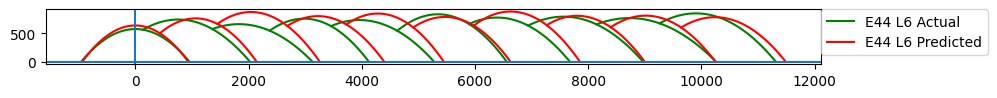

In [ ]:
single_sample_df = pd.DataFrame(columns=['sample_name', 'layer_num', 'curve_num', 'actual_height', 'predicted_height', 'actual_waviness', 'predicted_waviness'])

unique_sample_numbers = np.unique(final_arr[:, 0, 3])
unique_layer_numbers = np.unique(final_arr[:, 0, 4])

for sample_number in unique_sample_numbers:
    for layer_number in unique_layer_numbers:
        sample_mask_pred = final_arr[:, 0, 3] == sample_number
        layer_mask_pred = final_arr[:, 0, 4] == layer_number
        mask_pred = np.logical_and(sample_mask_pred, layer_mask_pred)

        sample_mask_act = test_outputs_np_denorm_labelled[:, 0, 3] == sample_number
        layer_mask_act = test_outputs_np_denorm_labelled[:, 0, 4] == layer_number
        mask_act = np.logical_and(sample_mask_act, layer_mask_act)

        if np.any(mask_pred) or np.any(mask_act):
            coef_pred = []
            root_points_pred = []
            cross_points_pred = []
            point_chain_pred = []
            coef_act = []
            root_points_act = []
            cross_points_act = []
            point_chain_act = []
            hatch_spacing = process_parameters.loc[sample_number, 'Hatching Spacing']
            x_range = np.arange(-10, 11)

            if np.any(mask_pred):
                test_filtered_pred = final_arr[mask_pred]
                pred_coef_filtered = final_arr_coef[mask_pred]
    

                for i in range(len(test_filtered_pred)):
                    try:
                        xy_offset = hatch_spacing * int(test_filtered_pred[i,0,5])
                        a, b, c = pred_coef_filtered[i][0]
                        y_vals = a * x_range ** 2 + b * x_range + c
                        points = np.stack((x_range, y_vals), axis=-1)
                        coefficient = np.polyfit(points[:, 0:1].flatten()+xy_offset, points[:, 1:2].flatten(), 2, full=False)
                        p = np.poly1d(coefficient)
                        roots = np.roots(coefficient)
                        root_points_pred.append(roots)
                        coef_pred.append(coefficient)
                        if i != 0:
                            intersect_point = np.roots(coef_pred[i - 1] - coef_pred[i])
                            intersect_point = intersect_point[p(intersect_point) > 0]
                            cross_points_pred.append(np.max(intersect_point[(intersect_point >= np.min(root_points_pred[i-1])) & (intersect_point <= np.max(root_points_pred[i-1]))]))
                    except (ValueError, IndexError) as e:
                        print(f"Error occurred for Sample Number: {sample_number}, Layer Number: {layer_number}")
                        continue

                point_chain_pred = np.concatenate(([np.min(root_points_pred[0])], cross_points_pred, [np.max(root_points_pred[-1])]))
                #plt_pred = PlotGraph(coef_pred, point_chain_pred, root_points_pred, sample_number, layer_number, color='red')
            
            if np.any(mask_act):
                test_filtered_act = test_outputs_np_denorm_labelled[mask_act]
                act_coef_filtered = test_outputs_coef[mask_act]

                for i in range(len(test_filtered_act)):
                    try:
                        xy_offset = hatch_spacing * int(test_filtered_act[i,0,5])
                        a, b, c = act_coef_filtered[i][0]
                        y_vals = a * x_range ** 2 + b * x_range + c
                        points = np.stack((x_range, y_vals), axis=-1)
                        coefficient = np.polyfit(points[:, 0:1].flatten()+xy_offset, points[:, 1:2].flatten(), 2, full=False)
                        if np.any(~np.isfinite(coefficient)):
                            raise ValueError("Invalid coefficient array")
                        p = np.poly1d(coefficient)
                        roots = np.roots(coefficient)
                        root_points_act.append(roots)
                        coef_act.append(coefficient)
                        if i != 0:
                            intersect_point = np.roots(coef_act[i - 1] - coef_act[i])
                            intersect_point = intersect_point[p(intersect_point) > 0]
                            cross_points_act.append(np.max(intersect_point[(intersect_point >= np.min(root_points_act[i-1])) & (intersect_point <= np.max(root_points_act[i-1]))]))
                    except (ValueError, IndexError) as e:
                        print(f"Error occurred for Sample Number: {sample_number}, Layer Number: {layer_number}")
                        continue

                point_chain_act = np.concatenate(([np.min(root_points_act[0])], cross_points_act, [np.max(root_points_act[-1])]))
                #plt_act = PlotGraph(coef_act, point_chain_act, root_points_act, sample_number, layer_number, color='green')
            
            if np.any(mask_act) and np.any(mask_pred):
              heights_pred = []
              heights_act = []
              waviness_pred = []
              waviness_act = []

              for i, (coef_p, coef_a) in enumerate(zip(coef_pred, coef_act)):
                  p_pred = np.poly1d(coef_p)
                  p_act = np.poly1d(coef_a)

                  # Obtain height        
                  max_height_pred = p_pred(np.roots(p_pred.deriv()))[0]
                  max_height_act = p_act(np.roots(p_act.deriv()))[0]

                  # Obtain waviness 
                  if i != 0:
                      intersect_point_pred = np.roots(coef_pred[i - 1] - coef_pred[i])
                      intersect_point_pred = intersect_point_pred[p_pred(intersect_point_pred) > 0]
                      cross_point_pred = np.max(intersect_point_pred[(intersect_point_pred >= np.min(root_points_pred[i-1])) & (intersect_point_pred <= np.max(root_points_pred[i-1]))])

                      intersect_point_act = np.roots(coef_act[i - 1] - coef_act[i])
                      intersect_point_act = intersect_point_act[p_act(intersect_point_act) > 0]
                      cross_point_act = np.max(intersect_point_act[(intersect_point_act >= np.min(root_points_act[i-1])) & (intersect_point_act <= np.max(root_points_act[i-1]))])

                      waviness_pred.append(max_height_pred - p_pred(cross_point_pred))
                      waviness_act.append(max_height_act - p_act(cross_point_act))

                  heights_pred.append(max_height_pred)
                  heights_act.append(max_height_act)

                  row_data = pd.DataFrame([{
                      'sample_name': sample_number,
                      'layer_num': layer_number,
                      'curve_num': i,
                      'predicted_height': max_height_pred,
                      'actual_height': max_height_act,
                      'predicted_waviness': waviness_pred[-1] if i != 0 else 0,
                      'actual_waviness': waviness_act[-1] if i != 0 else 0
                  }])
                  single_sample_df = pd.concat([single_sample_df, row_data], ignore_index=True)
                  if i ==0:

                    plt_combined = PlotGraph([coef_act, coef_pred], [point_chain_act, point_chain_pred], [root_points_act, root_points_pred],
                                                sample_number, layer_number, colors=['green', 'red'])
                    plt_combined.plot_ax()
                  else:
                    pass


In [ ]:
#Original predicted height
select_sample_df = shape_df[(shape_df['sample_name'] == 'E44') & (shape_df['layer_num'] == 'L6')]


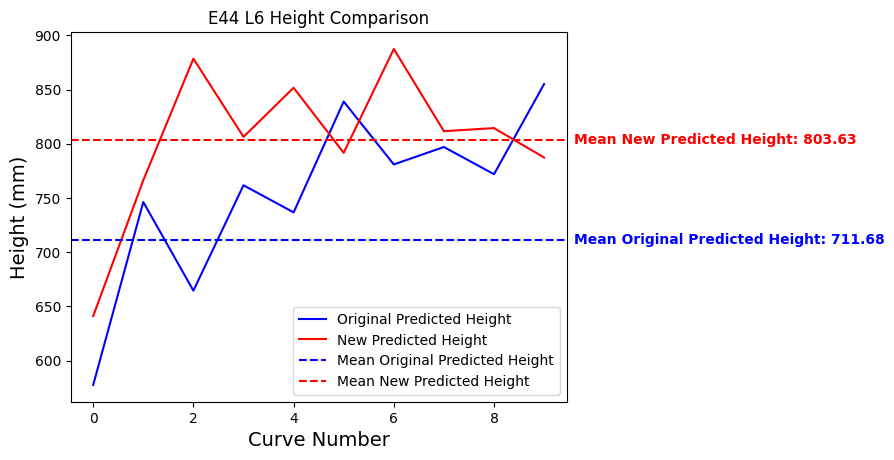

In [ ]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()

# make a plot
ax.plot(single_sample_df['curve_num'], select_sample_df['actual_height'], color="blue", label="Original Predicted Height")
ax.plot(single_sample_df['curve_num'], single_sample_df['predicted_height'], color="red", label="New Predicted Height")

# set x-axis label
ax.set_xlabel("Curve Number",fontsize=14)

# set y-axis label
ax.set_ylabel("Height (mm)",color="black",fontsize=14)

# add horizontal line for mean actual height
mean_actual_height = select_sample_df['predicted_height'].mean()
ax.axhline(y=mean_actual_height, color='blue', linestyle='--', label="Mean Original Predicted Height")

# add horizontal line for mean predicted height
mean_predicted_height = single_sample_df['predicted_height'].mean()
ax.axhline(y=mean_predicted_height, color='red', linestyle='--', label="Mean New Predicted Height")

# add legend
ax.legend()

# add annotations for mean values
ax.annotate("Mean Original Predicted Height: {:.2f}".format(mean_actual_height), xy=(1, mean_actual_height), xytext=(310, 0), textcoords='offset points', ha='left', va='center', color='blue', fontweight='bold')
ax.annotate("Mean New Predicted Height: {:.2f}".format(mean_predicted_height), xy=(1, mean_predicted_height), xytext=(310, 0), textcoords='offset points', ha='left', va='center', color='red', fontweight='bold')

ax.set_title('E44 L6 Height Comparison')
# show plot
plt.show()